# Analysis
Created by Ivan Lima on 2020-04-07 20:11:35 

In this notebook we examine gender differences in NSF Ocean Sciences awards between 1987 and 2019. The metrics we use for gender discrepancies are the annual percentage of female PIs and co-PIs in the awards. We track those metrics across: 

1. All NSF-OCE awards.
2. Awards from the top 10 largest NSF programs (in number of awards).
3. Across the top 10 academic organizations (in number of awards).
4. Identified research topics.
5. Award types

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime
import matplotlib.pyplot as plt
import warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Sun Jan 31 17:51:03 2021


In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 50

Read NSF-OCE award data.

In [3]:
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)

topic_probs = pd.read_csv('results/topic_probs.csv', index_col=0)
topic_words = pd.read_csv('results/topic_words.csv', index_col=0)

npzfile = np.load('results/NMF_TSNE.npz')
feature_names  = npzfile['feature_names']
nmf_components = npzfile['nmf_components']
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
X_tsne         = npzfile['X_tsne']
npzfile.close()
# awards.info()

# Read geosciences/atmospheric/ocean sciences academic gender workforce data
workforce = pd.read_csv('data/nsf_workforce.csv')#, index_col=0)
workforce['female_frac'] = workforce.female/workforce.total

awards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11513 entries, 8911427 to 844394
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Abstract             11513 non-null  string        
 1   Title                11513 non-null  string        
 2   Programs             11491 non-null  string        
 3   StartDate            11513 non-null  datetime64[ns]
 4   EndDate              11513 non-null  datetime64[ns]
 5   PI                   11481 non-null  string        
 6   Organization         11513 non-null  string        
 7   State                11364 non-null  string        
 8   Instrument           11513 non-null  string        
 9   n_awards             11513 non-null  int64         
 10  co-PIs               5784 non-null   string        
 11  num_co-PIs           5784 non-null   float64       
 12  total_amount         11513 non-null  float64       
 13  total_ARRA           115

## All NSF-OCE awards

The figure below shows the number of awards and the amount awarded by NSF Ocean Sciences per year, and a box plot of the amount awarded to individual projects in each year between 1987 and 2019.

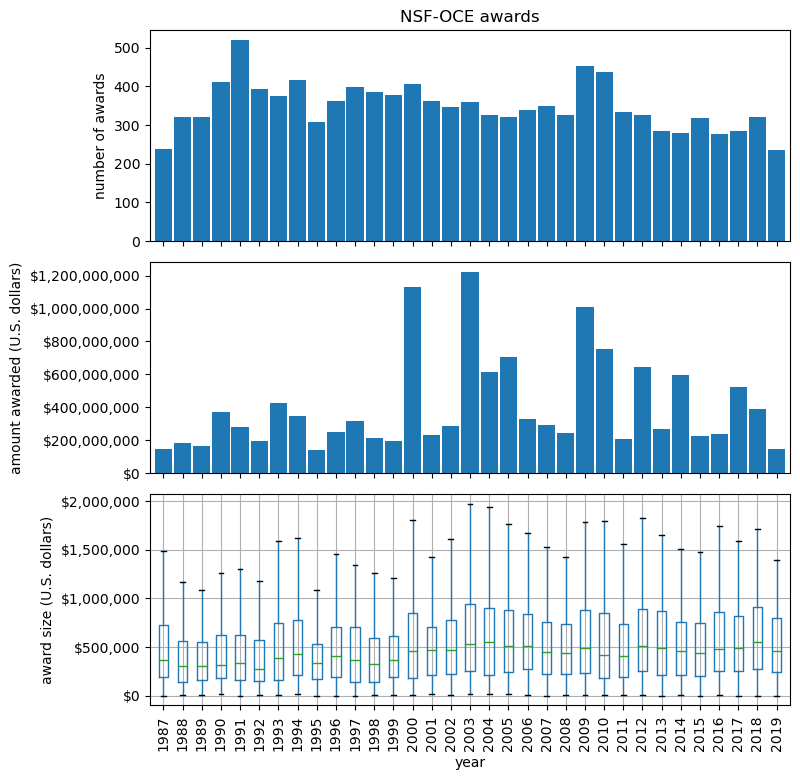

In [4]:
from matplotlib import ticker
def dollar(x, pos):
    return '${:,.0f}'.format(x)
fmt = ticker.FuncFormatter(dollar)

number_per_year = awards.groupby(awards.StartDate.dt.year)['Abstract'].count()
amount_per_year = awards.groupby([awards.StartDate.dt.year])['tot_amount_adjusted'].sum()
awards['year'] = awards.StartDate.dt.year

fig, axs = plt.subplots(3, 1, figsize=(8,9))
_ = number_per_year.plot(kind='bar',ax=axs[0], width=0.9, legend=False)
_ = axs[0].set(title='NSF-OCE awards', ylabel='number of awards', xticklabels='', xlabel='')
_ = amount_per_year.plot(kind='bar',ax=axs[1], width=0.9)
_ = axs[1].yaxis.set_major_formatter(fmt)
_ = axs[1].set(ylabel='amount awarded (U.S. dollars)', xticklabels='', xlabel='')
_ = awards.boxplot('tot_amount_adjusted', by='year', showfliers=False,rot=90, ax=axs[2])
_ = axs[2].yaxis.set_major_formatter(fmt)
_ = axs[2].set(title='', ylabel='award size (U.S. dollars)')
_ = axs[2].set_xlim(0.3, 33.7)
fig.suptitle('')
fig.subplots_adjust(hspace=0.1)

### Award size by PI gender

Statistics of the individual awards received by male and female PIs.

In [5]:
awards_male = awards[awards.PI_gender == 'male'][['StartDate','tot_amount_adjusted']]
awards_female = awards[awards.PI_gender == 'female'][['StartDate','tot_amount_adjusted']]

stats = pd.DataFrame({'male PIs': awards_male.tot_amount_adjusted.describe(),
                      'female PIs':awards_female.tot_amount_adjusted.describe()})
stats

male PIs    female PIs
count  9.271000e+03  2.146000e+03
mean   1.186963e+06  1.047491e+06
std    1.221179e+07  1.539015e+07
min    0.000000e+00  0.000000e+00
25%    1.974344e+05  1.820283e+05
50%    4.218187e+05  4.111775e+05
75%    7.603440e+05  7.341902e+05
max    8.472425e+08  7.019176e+08

Box plot of the amount awarded (award size) to individual projects by male and female PIs. Median and range seem to be about the same. The difference between the mean award size for male and female PIs is not statistically significant.

T-test for equal means: t=0.452, p=0.651, df=11415


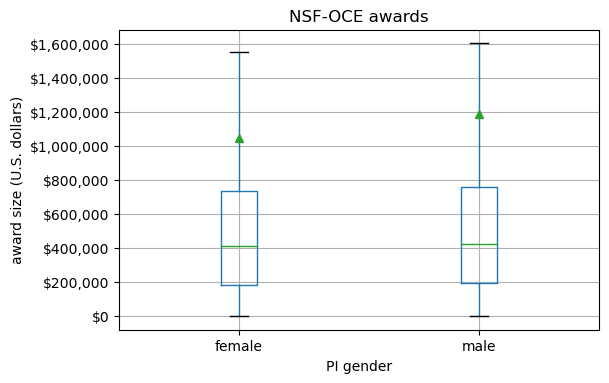

In [6]:
fig, ax = plt.subplots()
_ = awards.boxplot('tot_amount_adjusted', by='PI_gender', showfliers=False, showmeans=True, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender', ylabel='award size (U.S. dollars)')
_ = fig.suptitle('')

male = awards_male.tot_amount_adjusted.values
female = awards_female.tot_amount_adjusted.values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}'.format(tstat, pval, df))

Box plot of the amount awarded to individual projects by male and female PIs in each year and t-test for equal means.

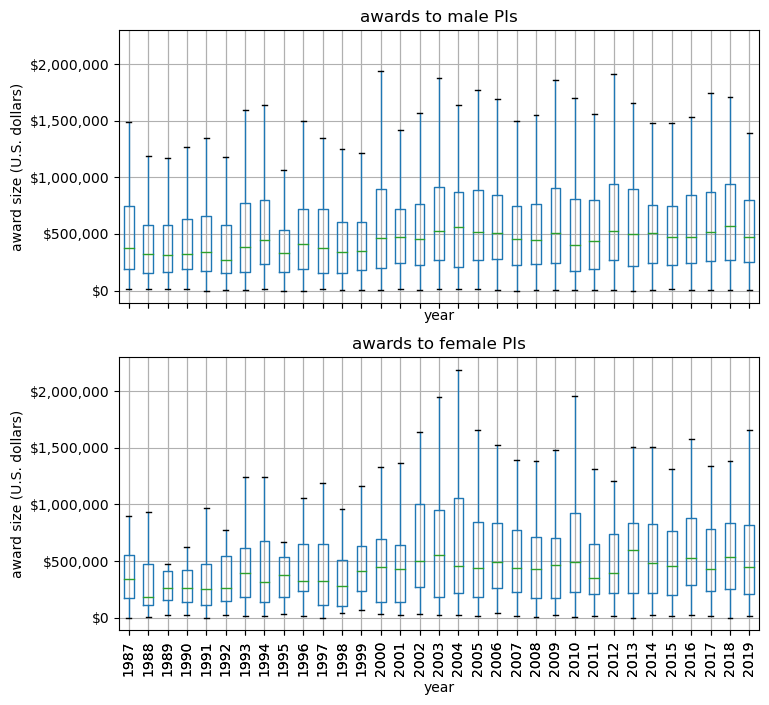

In [7]:
awards_male['year'] = awards_male.StartDate.dt.year
awards_female['year'] = awards_female.StartDate.dt.year

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,8))
_ = awards_male.boxplot('tot_amount_adjusted', by='year', showfliers=False, rot=90, ax=axs[0])
_ = awards_female.boxplot('tot_amount_adjusted', by='year', showfliers=False, rot=90, ax=axs[1])
axs[0].set_title('awards to male PIs')
axs[1].set_title('awards to female PIs')
for n in range(2):
    _ = axs[n].yaxis.set_major_formatter(fmt)
    _ = axs[n].set(ylabel='award size (U.S. dollars)')
_ = fig.suptitle('')

Time series of median award size to male and female PIs.

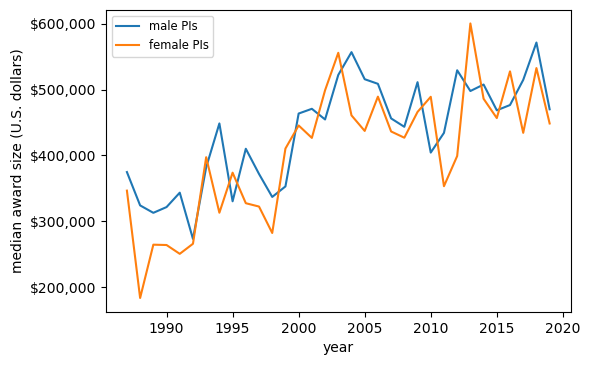

In [8]:
median_award = pd.DataFrame({'male PIs': awards_male.groupby('year')['tot_amount_adjusted'].median(),
                             'female PIs': awards_female.groupby('year')['tot_amount_adjusted'].median()})
fig, ax = plt.subplots()
_ = median_award.plot(ax=ax)
_ = ax.set(ylabel='median award size (U.S. dollars)')
_ = ax.yaxis.set_major_formatter(fmt)

### Percentage of female co-PIs by PI gender

Box plot of the percentage of female co-PIs by PI gender and t-test for equal means. Awards with female PIs have a higher percentage of female co-PIs and the difference between the means is statistically significant.

T-test for equal means: t=-7.764, p=0.000, df=5726



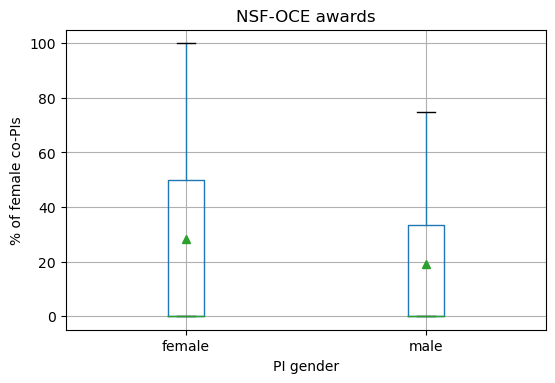

In [9]:
awards_with_copis = awards[awards['num_co-PIs'].notnull()]
awards_with_copis['co-PI_female_pct'] = awards_with_copis['co-PI_female_frac'] * 100

fig, ax = plt.subplots()
_ = awards_with_copis.boxplot('co-PI_female_pct', by='PI_gender', showfliers=False, showmeans=True, ax=ax)
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender', ylabel='% of female co-PIs')
_ = fig.suptitle('')

df_male = awards_with_copis[awards_with_copis.PI_gender=='male']
df_female = awards_with_copis[awards_with_copis.PI_gender=='female']
male = df_male['co-PI_female_pct'].dropna().values
female = df_female['co-PI_female_pct'].dropna().values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}\n'.format(tstat, pval, df))

s1 = awards_with_copis.groupby(['PI_gender'])['co-PI_female_pct'].mean()
s2 = awards_with_copis.groupby(['PI_gender'])['co-PI_female_pct'].count()
df = pd.concat([s1,s2], axis=1, keys=['mean', 'number of awards'])
df.style.format('{0:,.2f}%', subset='mean')

The figure below shows a time series of the annual mean percentage of female co-PIs by PI gender. The shaded area represents the 95% confidence interval of the annual means. For most of the period, the 95% confidence interval overlaps with the lines. So the differences between the annual means from female and male PIs are not statistically significant except for the years 2001, 2003, 2009, 2017 and 2019, as the t-test shows. One possible reason for that is that before 2000, the confidence interval for female PIs is wider due to the realtively low number of awards with female PIs (zero in 1989). As the number of female PI increases, the confidence interval narrows a bit (variance decreases) and we start to see differences that are statistically significant. Nevertheless, the figure indicates that awards with female PIs tend to have a higher percentage of female co-PIs.

Years in which difference between means is statistically significant (p<0.05):

2001 t=-2.670, p=0.008, df=180
2003 t=-2.788, p=0.006, df=209
2009 t=-3.907, p=0.000, df=251
2017 t=-3.366, p=0.001, df=171
2019 t=-2.412, p=0.017, df=124



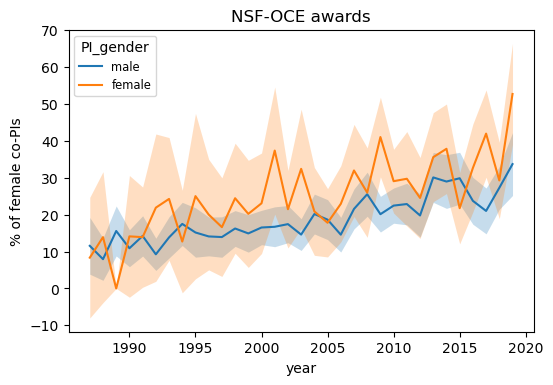

In [10]:
copi_gender_by_pi_gender = awards_with_copis.groupby(['year','PI_gender'])['co-PI_female_pct'].mean().unstack()

f_error = lambda x: 1.96 * x.std()/np.sqrt(x.size)
error = awards_with_copis.groupby(['year','PI_gender'])['co-PI_female_pct'].apply(f_error).unstack()

fig, ax = plt.subplots()
_ = copi_gender_by_pi_gender[['male','female']].plot(ax=ax)
x, y_male, y_female = copi_gender_by_pi_gender.index, copi_gender_by_pi_gender.male, copi_gender_by_pi_gender.female
_ = ax.fill_between(x, y_male - error.male, y_male + error.male, alpha=0.25, color='C0', linewidth=0)
_ = ax.fill_between(x, y_female - error.female, y_female + error.female, color='C1', alpha=0.25, linewidth=0)
_ = ax.set(ylabel='% of female co-PIs', title='NSF-OCE awards')

print('Years in which difference between means is statistically significant (p<0.05):\n')
for year in copi_gender_by_pi_gender.index.values:
    male = awards_with_copis[(awards_with_copis.year==year) & (awards_with_copis.PI_gender=='male')]['co-PI_female_pct'].dropna().values
    female = awards_with_copis[(awards_with_copis.year==year) & (awards_with_copis.PI_gender=='female')]['co-PI_female_pct'].dropna().values
    tstat, pval, df = sm.stats.ttest_ind(male, female)
    if pval < 0.05:
        print('{} t={:.3f}, p={:.3f}, df={:.0f}'.format(year, tstat, pval, df))

print('')

### Number of co-PIs by PI gender

Box plot of the number of co-PIs by PI gender and t-test for equal means. Awards with female PIs have a higher number co-PIs. The difference between the means is small but statistically significant.

T-test for equal means: t=-2.668, p=0.008, df=5730



mean  number of awards
PI_gender                            
female     1.812050              1112
male       1.706277              4620

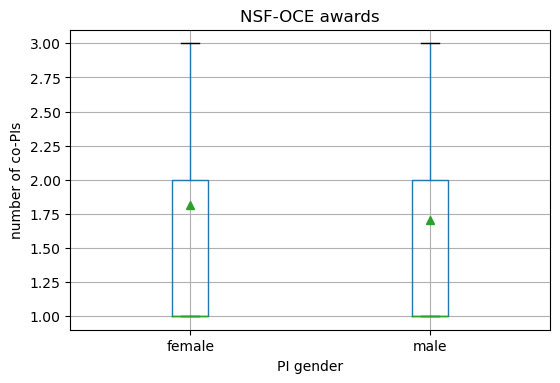

In [11]:
fig, ax = plt.subplots()
_ = awards_with_copis.boxplot('num_co-PIs', by='PI_gender', showfliers=False, showmeans=True, ax=ax)
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender', ylabel='number of co-PIs')
_ = fig.suptitle('')

df_male = awards_with_copis[awards_with_copis.PI_gender=='male']
df_female = awards_with_copis[awards_with_copis.PI_gender=='female']
male = df_male['num_co-PIs'].dropna().values
female = df_female['num_co-PIs'].dropna().values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}\n'.format(tstat, pval, df))

s1 = awards_with_copis.groupby(['PI_gender'])['num_co-PIs'].mean()
s2 = awards_with_copis.groupby(['PI_gender'])['num_co-PIs'].count()
df = pd.concat([s1,s2], axis=1, keys=['mean', 'number of awards'])
df

The figure below shows a time series of the annual mean number of co-PIs by PI gender. The shaded area represents the 95% confidence interval of the annual means.

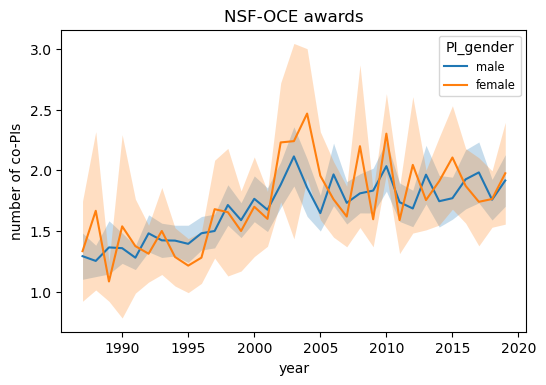

In [12]:
df_num_copi = awards_with_copis.groupby(['year','PI_gender'])['num_co-PIs'].mean().unstack()
error = awards_with_copis.groupby(['year','PI_gender'])['num_co-PIs'].apply(f_error).unstack()

fig, ax = plt.subplots()
_ = df_num_copi[['male','female']].plot(ax=ax)
x, y_male, y_female = df_num_copi.index, df_num_copi.male, df_num_copi.female
_ = ax.fill_between(x, y_male - error.male, y_male + error.male, alpha=0.25, color='C0', linewidth=0)
_ = ax.fill_between(x, y_female - error.female, y_female + error.female, color='C1', alpha=0.25, linewidth=0)
_ = ax.set(ylabel='number of co-PIs', title='NSF-OCE awards')

### Award interdisciplinarity by PI gender

Box plot of the award interdisciplinarity by PI gender and t-test for equal means.

T-test for equal means: t=-1.126, p=0.260, df=5730



mean  number of awards
PI_gender                            
female     0.479725              1112
male       0.473684              4620

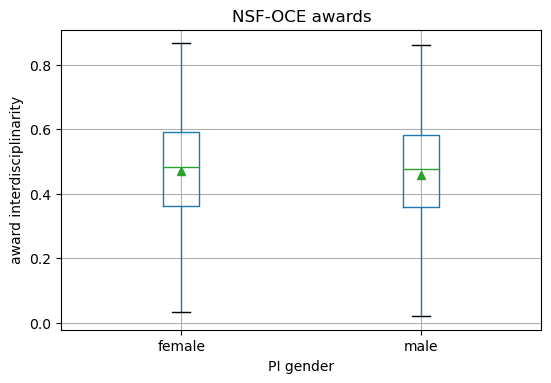

In [13]:
fig, ax = plt.subplots()
_ = awards.boxplot('evenness', by='PI_gender', showfliers=False, showmeans=True, ax=ax)
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender', ylabel='award interdisciplinarity')
_ = fig.suptitle('')

df_male = awards_with_copis[awards_with_copis.PI_gender=='male']
df_female = awards_with_copis[awards_with_copis.PI_gender=='female']
male = df_male['evenness'].dropna().values
female = df_female['evenness'].dropna().values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}\n'.format(tstat, pval, df))

s1 = awards_with_copis.groupby(['PI_gender'])['evenness'].mean()
s2 = awards_with_copis.groupby(['PI_gender'])['evenness'].count()
df = pd.concat([s1,s2], axis=1, keys=['mean', 'number of awards'])
df

The figure below shows a time series of the annual mean award interdisciplinarity by PI gender. The shaded area represents the 95% confidence interval of the annual means.

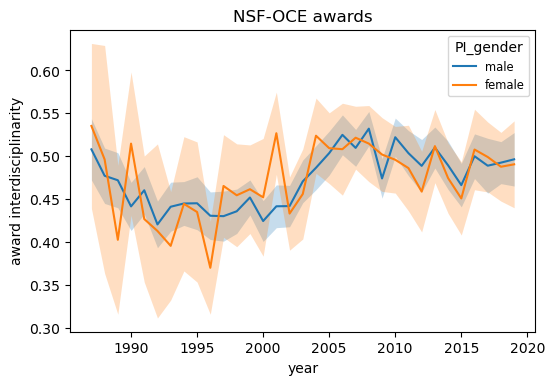

In [14]:
df_num_copi = awards_with_copis.groupby(['year','PI_gender'])['evenness'].mean().unstack()
error = awards_with_copis.groupby(['year','PI_gender'])['evenness'].apply(f_error).unstack()

fig, ax = plt.subplots()
_ = df_num_copi[['male','female']].plot(ax=ax)
x, y_male, y_female = df_num_copi.index, df_num_copi.male, df_num_copi.female
_ = ax.fill_between(x, y_male - error.male, y_male + error.male, alpha=0.25, color='C0', linewidth=0)
_ = ax.fill_between(x, y_female - error.female, y_female + error.female, color='C1', alpha=0.25, linewidth=0)
_ = ax.set(ylabel='award interdisciplinarity', title='NSF-OCE awards')

### Temporal trends in gender composition

The figure below shows the time series of the annual percentage of female PIs and co-PIs across all awards and the percentage of females in the academic workforce between 1987 and 2019. The shaded area represents the 95% confidence interval of the annual means for the co-PIs. There is no confidence interval for the PIs and workforce because the data consists of annual mean values for these categories.
<!-- Solid lines represent a 3-year sliding window average (except for workforce data) and points represent the individual years. -->

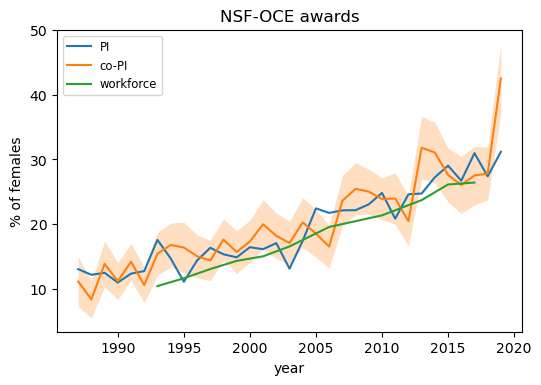

In [15]:
# female & male fraction of PIs
pi_gender = awards.groupby([awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender = pi_gender.divide(pi_gender.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender = pd.DataFrame({'female':awards.groupby(awards.StartDate.dt.year)['co-PI_female_frac'].mean()})
copi_gender['male'] = 1 - copi_gender.female

# female percentage of PIs & co-PIs
female_pct = pd.DataFrame({'PI':pi_gender['female'] * 100, 'co-PI':copi_gender['female'] * 100})
female_pct.index.rename('year',inplace=True)

awards['co-PI_female_pct'] = awards['co-PI_female_frac'] * 100
error = awards.groupby(awards.StartDate.dt.year)['co-PI_female_pct'].apply(f_error)

workforce['female_pct'] = workforce['female_frac'] * 100

fig, ax = plt.subplots()
_ = female_pct.plot(ax=ax, legend=False)
_ = workforce.plot(x='year', y='female_pct', ax=ax, label='workforce', legend=False)
x, y_female = female_pct.index, female_pct['co-PI']
_ = ax.fill_between(x, y_female - error, y_female + error, color='C1', alpha=0.25, linewidth=0)
_ = ax.set(title='NSF-OCE awards', ylabel='% of females')
lines = ax.get_lines()
_ = ax.legend(lines,['PI','co-PI','workforce'])

A linear regression fits the data well and female participation in NSF-OCE awards and the workforce seem to be increasing at a rate of approximately 0.65% per year.

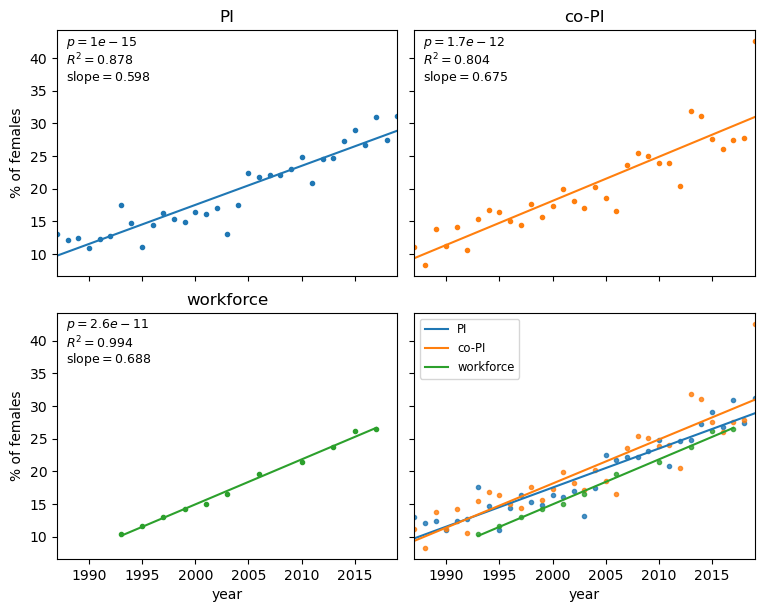

In [16]:
import seaborn as sns

def linreg(x, y):
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    return lreg, X

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 7))
fig.subplots_adjust(wspace=0.05, hspace=0.15)
_ = female_pct.PI.plot(ax=axs[0,0], style='C0.')
_ = axs[0,0].set(title='PI', ylabel='% of females')
_ = female_pct['co-PI'].plot(ax=axs[0,1], style='C1.')
_ = axs[0,1].set(title='co-PI')
_ = workforce.plot(x='year', y='female_pct', ax=axs[1,0], style='C2.', legend=False)
_ = axs[1,0].set(title='workforce', ylabel='% of females')

for ax, x, y, s in zip(axs.ravel(),[female_pct.index, female_pct.index, workforce.year],
                       [female_pct.PI, female_pct['co-PI'], workforce.female_pct],['C0-','C1-','C2-']):
    reg, X = linreg(x, y)
    p, slope, rsquared = reg.pvalues[1], reg.params[1], reg.rsquared
    _ = ax.plot(x, reg.predict(X), s)
    _ = ax.text(0.025,0.95, '$p={:.2g}$'.format(p), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    _ = ax.text(0.025,0.88, '$R^2={:.3g}$'.format(rsquared), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    _ = ax.text(0.025,0.81, 'slope$={:.3f}$'.format(slope), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)

_ = sns.regplot(female_pct.index,female_pct.PI, ax=axs[1,1], marker='.', ci=None, line_kws={'linewidth':1.5})
_ = sns.regplot(female_pct.index,female_pct['co-PI'], ax=axs[1,1], marker='.', ci=None, line_kws={'linewidth':1.5})
_ = sns.regplot(workforce.year,workforce.female_pct, ax=axs[1,1], marker='.', ci=None, line_kws={'linewidth':1.5})
lines = axs[1,1].get_lines()
_ = axs[1,1].legend(lines,['PI','co-PI','workforce'], loc='upper left')

We use a multivariate linear regression of *female percentage* on *time* (year), *category* (PI or co-PI) plus an interaction term (*time* $\times$ *category*) to test whether the temporal trend (slope) and the mean female percentage (intercept) are different between PIs and co-PIs. The table below shows the results from the multivariate linear regression. The large $p$ values for *category* and the interaction term indicate that the differences in intercept and regression slope between PIs and co-PIs are not statistically significant.

In [17]:
import statsmodels.formula.api as smf

df_pi = pd.DataFrame({'fem_pct':female_pct['PI'], 'category':'PI'})
df_copi = pd.DataFrame({'fem_pct':female_pct['co-PI'], 'category':'co-PI'})
df  = pd.concat([df_pi,df_copi]).reset_index()
lreg = smf.ols(formula='fem_pct ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                fem_pct   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     105.1
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           2.86e-24
Time:                        17:51:11   Log-Likelihood:                -159.18
No. Observations:                  66   AIC:                             326.4
Df Residuals:                      62   BIC:                             335.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1178.2040    101.967    -11.555      0.000   -1382.033    -974.375
category[T.co-PI]       -153.4001    144.203     -1.064      0.292    -441.657     134.857
year                       0.5979      0.051     11.744      0.000       0.496       0.700
year:category[T.co-PI]     0.0770      0.072      1.070      0.289      -0.067       0.221
==============================================================================
Omnibus:                       20.244   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.334
Skew:                           0.879   Prob(JB):                     1.94e-11
Kurtosis:                       6.854   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression slopes for the award and workforce data are very similar (~0.006). We use a similar multivariate linear regression model of *female percentage* on *time* (year) and *category* (PI, co-PI & workforce) to test if the mean female percentage (intercept) is different between PIs, co-PIs and the workforce. As shown above, the $p$ value (table below) for the co-PI category term indicates that the difference between female representation in PIs and co-PIs is not statistically significant. However, the $p$ value for the workforce category term shows that the lower female percentage in the workforce is statistically significant. This difference is probably because the workforce data represents a wider range of fields, including earth and atmospheric and ocean sciences.

In [18]:
df_work = pd.DataFrame({'fem_pct':workforce.set_index('year').female_pct, 'category':'workforce'})
df  = pd.concat([df_pi,df_copi,df_work]).reset_index()
lreg = smf.ols(formula='fem_pct ~ year + category', data=df)
# lreg = smf.ols(formula='fem_pct ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                fem_pct   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     137.7
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           5.67e-30
Time:                        17:51:11   Log-Likelihood:                -180.76
No. Observations:                  77   AIC:                             369.5
Df Residuals:                      73   BIC:                             378.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1266.1912     63.714    -19.873      0.000   -1393.172   -1139.210
category[T.co-PI]         0.8479      0.640      1.325      0.189      -0.428       2.123
category[T.workforce]    -2.2305      0.906     -2.461      0.016      -4.037      -0.424
year                      0.6418      0.032     20.177      0.000       0.578       0.705
==============================================================================
Omnibus:                       32.343   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.881
Skew:                           1.167   Prob(JB):                     2.07e-27
Kurtosis:                       8.732   Cond. No.                     4.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Reference female percentage in academic workforce

As we have seen above, the difference between the regression parameters (slope and intercept) of the percentage of female PIs and co-PIs in NSF awards is not statistically significant. Average percentage of females in the workforce is slightly lower than that in NSF awards (different intercept), but that is most likely a result of the inclusion of earth and atmospheric sciences in the workforce data. Thus, we assume that the temporal trends we see in the percentage of female PIs and co-PIs in NSF awards represent the increasing participation of females in the ocean sciences academic workforce. We then use the linear trend (regression) of the combined data (PIs & co-PIs) as a reference to compare temporal changes in female participation across NSF programs, organizations, research topics and award types with that in the ocean sciences academic workforce.

Combining the PI and co-PI data we get the regression:

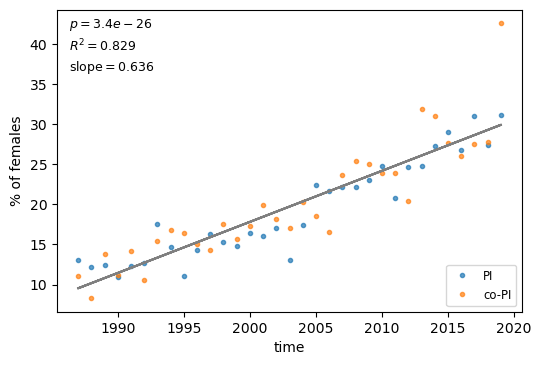

In [19]:
df  = pd.concat([df_pi,df_copi]).reset_index()
lreg_all, X = linreg(df.year, df.fem_pct)
fig, ax = plt.subplots()
_ = ax.plot(df_pi.index, df_pi.fem_pct,'.', label='PI', alpha=0.7)
_ = ax.plot(df_copi.index, df_copi.fem_pct,'.', label='co-PI', alpha=0.7)
_ = ax.plot(df.year, lreg_all.predict(X), 'C7')
_ = ax.legend(loc='lower right')
p, slope, rsquared = lreg_all.pvalues[1], lreg_all.params[1], lreg_all.rsquared
a, b = lreg_all.params
# title = '$y = {:.2f} + {:.3f}\,x$'.format(a, b)
_ = ax.text(0.025,0.95, '$p={:.2g}$'.format(p), transform=ax.transAxes, ha='left',
            va='center', fontsize=9)
_ = ax.text(0.025,0.88, '$R^2={:.3g}$'.format(rsquared), transform=ax.transAxes, ha='left',
            va='center', fontsize=9)
_ = ax.text(0.025,0.81, 'slope$={:.3f}$'.format(slope), transform=ax.transAxes, ha='left',
            va='center', fontsize=9)
_ = ax.set(xlabel='time', ylabel='% of females')#, title=title)

# Create DataFrame with "reference" female percentage in the ocean sciences academic workforce
years = df.year.unique()
df_ref = pd.DataFrame({'PI':lreg_all.predict(sm.add_constant(years)),
                       'co-PI':lreg_all.predict(sm.add_constant(years))}, index=years)
df_ref.index.name = 'StartDate'
df_ref.columns.name = 'female_pct'
# df_ref.to_csv('results/gender_ref.csv')

## NSF programs

### Top 10 NSF programs in number of awards

The table and histogram below show the top 10 NSF-OCE programs in number of awards for the period 1987-2019.

number of awards  percentage of total  \
program                                                                 
MARINE GEOLOGY AND GEOPHYSICS               2577            22.383393   
BIOLOGICAL OCEANOGRAPHY                     2121            18.422653   
PHYSICAL OCEANOGRAPHY                       1835            15.938504   
CHEMICAL OCEANOGRAPHY                       1347            11.699818   
OCEAN TECH & INTERDISC COORDIN               475             4.125771   
OCEANOGRAPHIC INSTRUMENTATION                453             3.934683   
SHIPBOARD SCIENTIFIC SUPP EQUI               377             3.274559   
OCEAN DRILLING PROGRAM                       281             2.440719   
EDUCATION/HUMAN RESOURCES                    249             2.162773   
MAJOR RESEARCH INSTRUMENTATION               171             1.485278   

                                cum percentage of total  
program                                                  
MARINE GEOLOGY AND GEOPHYSICS                 22.383393  
BIOLOGICAL OCEANOGRAPHY                       40.806045  
PHYSICAL OCEANOGRAPHY                         56.744550  
CHEMICAL OCEANOGRAPHY                         68.444367  
OCEAN TECH & INTERDISC COORDIN                72.570138  
OCEANOGRAPHIC INSTRUMENTATION                 76.504821  
SHIPBOARD SCIENTIFIC SUPP EQUI                79.779380  
OCEAN DRILLING PROGRAM                        82.220099  
EDUCATION/HUMAN RESOURCES                     84.382872  
MAJOR RESEARCH INSTRUMENTATION                85.868149

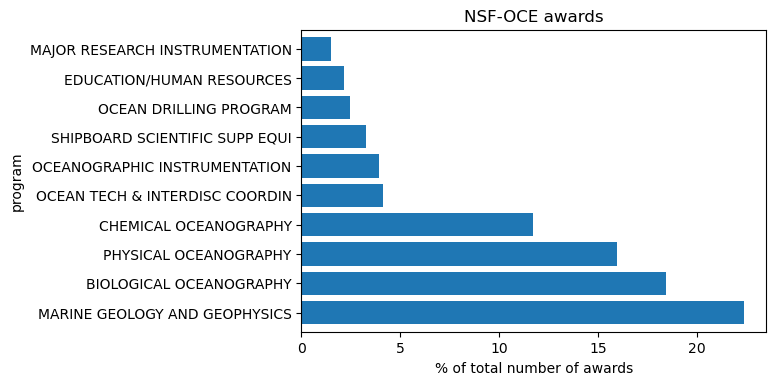

In [20]:
awards.loc[awards.program=='DATA NOT AVAILABLE','program'] = np.nan
top10_programs = pd.DataFrame({'number of awards':
                      awards.groupby('program')['Abstract'].count().sort_values(ascending=False)[:10]})
top10_programs['percentage of total'] = top10_programs['number of awards'] / len(awards) * 100
top10_programs['cum percentage of total'] = top10_programs['percentage of total'].cumsum() 

fig, ax = plt.subplots()
_ = top10_programs['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total number of awards')

top10_programs

Boxplot of award size by program.

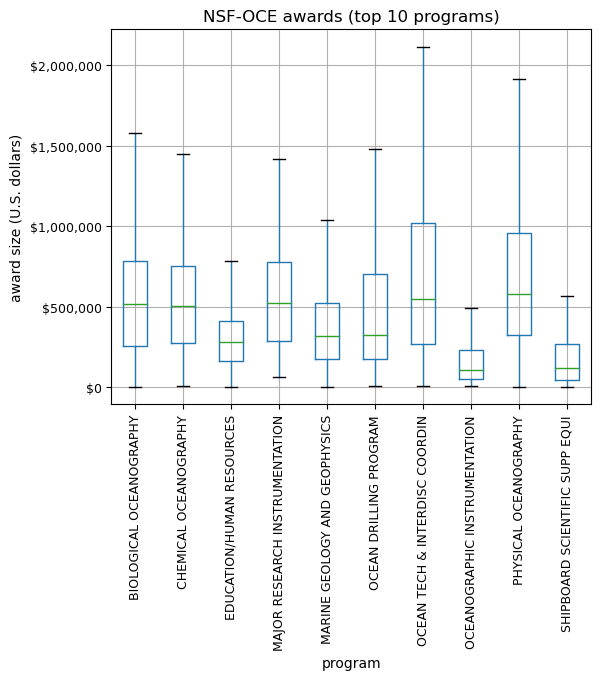

In [21]:
df = awards[awards.program.isin(top10_programs.index)]
fig, ax = plt.subplots(figsize=(6, 5))
_ = df.boxplot('tot_amount_adjusted', by='program', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards (top 10 programs)', ylabel='award size (U.S. dollars)')
_ = fig.suptitle('')

Boxplot of award interdisciplinarity by program.

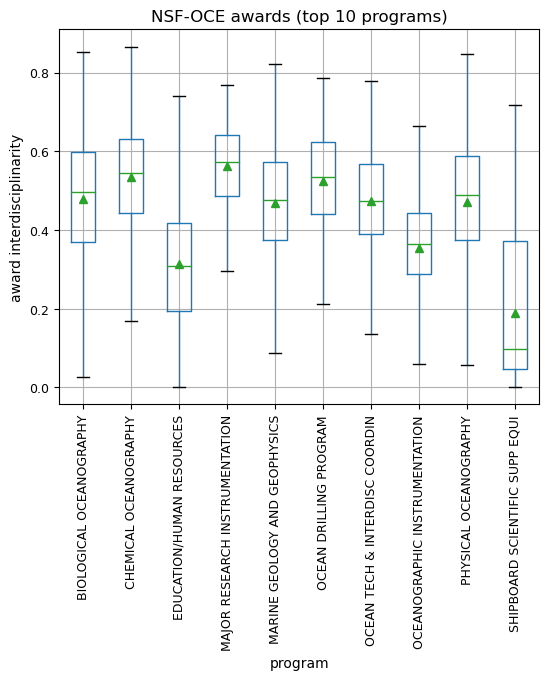

In [22]:
# meanprops = dict(markeredgecolor='C1', markerfacecolor='C1')
fig, ax = plt.subplots(figsize=(6, 5))
_ = df.boxplot('evenness', by='program', showfliers=False, showmeans=True,
               rot=90, fontsize=9, ax=ax)
_ = ax.set(title='NSF-OCE awards (top 10 programs)', ylabel='award interdisciplinarity')
_ = fig.suptitle('')

The figure below shows the time series of the number of awards and the percentage of awards per year for each of the top 10 programs.

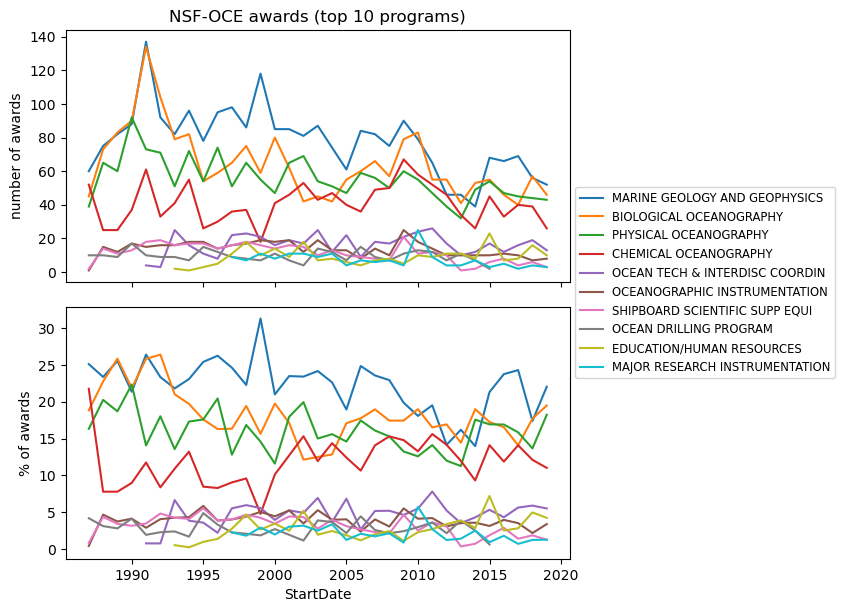

In [23]:
prog_year = awards.groupby([awards.StartDate.dt.year,'program'])['Abstract'].count().unstack()
prog_year = prog_year[top10_programs.index]
num_awards_per_year = awards.groupby([awards.StartDate.dt.year])['Abstract'].count()
prog_year_pct = prog_year.divide(num_awards_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.5,7))
fig.subplots_adjust(hspace=0.1)
_ = prog_year.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards (top 10 programs)')
_ = prog_year_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of awards')

### Top 10 NSF programs in total amount awarded

The table and histogram below show the top 10 NSF-OCE programs in total amount awarded for the period 1987-2019.

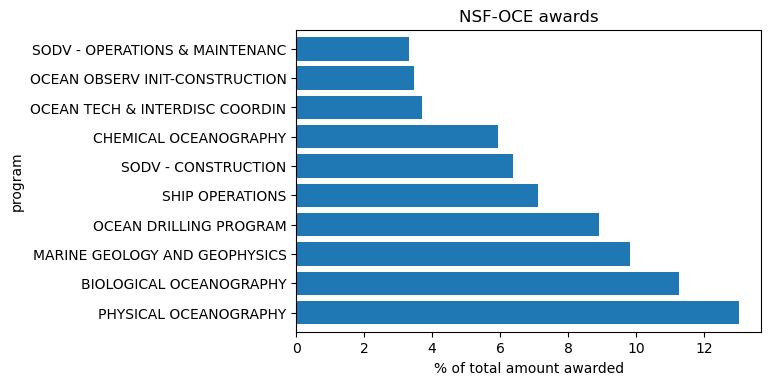

In [24]:
top10_programs_amount = pd.DataFrame({'amount awarded':
    awards.groupby('program')['tot_amount_adjusted'].sum().sort_values(ascending=False)[:10]})
top10_programs_amount['percentage of total'] = (top10_programs_amount['amount awarded'] /
                                         awards.tot_amount_adjusted.sum() * 100)
top10_programs_amount['cum percentage of total'] = top10_programs_amount['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = top10_programs_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total amount awarded')

top10_programs_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by program.

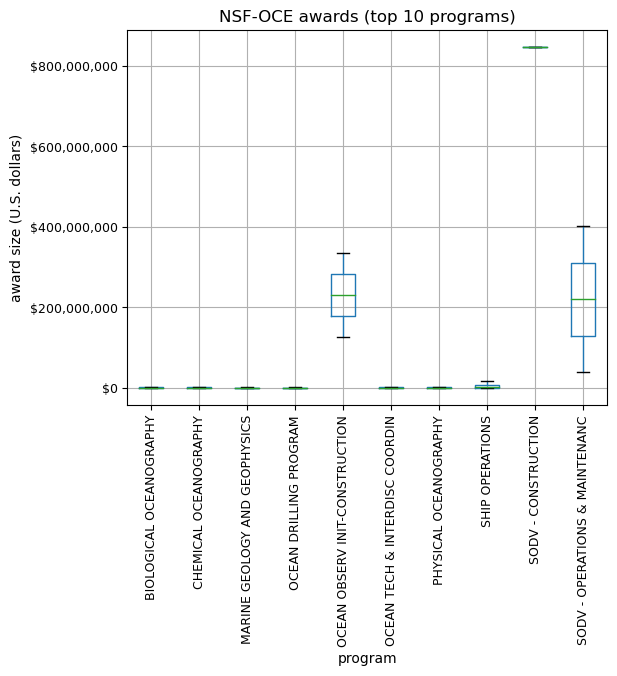

In [25]:
df = awards[awards.program.isin(top10_programs_amount.index)]
fig, ax = plt.subplots(figsize=(6, 5))
_ = df.boxplot('tot_amount_adjusted', by='program', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards (top 10 programs)', ylabel='award size (U.S. dollars)')
_ = fig.suptitle('')

The figure below shows the time series of the amount awarded and the percentage of the amount awarded per year for each of the top 10 programs.

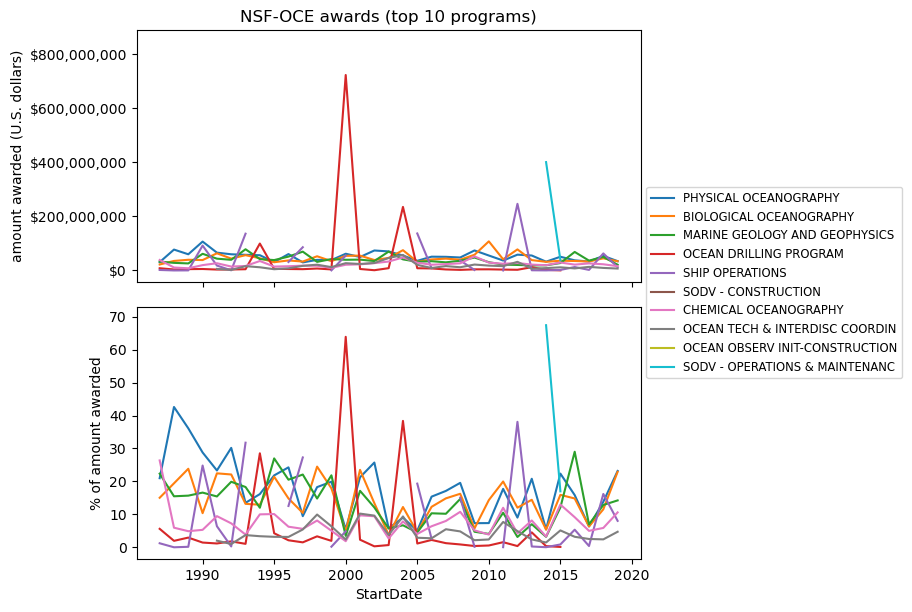

In [26]:
prog_year_amount = awards.groupby(
    [awards.StartDate.dt.year,'program'])['tot_amount_adjusted'].sum().unstack()
prog_year_amount = prog_year_amount[top10_programs_amount.index]
prog_year_amount_pct = prog_year_amount.divide(amount_per_year, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.5,7))
fig.subplots_adjust(hspace=0.1)
_ = prog_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards (top 10 programs)')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = prog_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

### Distribution of awards across top 10 NSF-OCE programs by PI gender

The table and figure show the relative frequency distribution of awards from each PI gender across the top 10 NSF-OCE programs (in number).

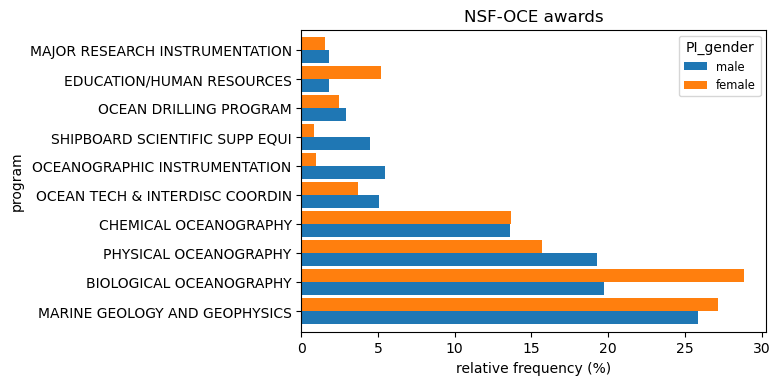

In [27]:
awards_top10 = awards[awards.program.isin(top10_programs.index)]

df_top10 = awards_top10.groupby(['program','PI_gender'])['Abstract'].count().unstack()
df_top10 = df_top10/df_top10.sum() * 100
# df_top10 = df_top10.sort_values('female', ascending=False)
df_top10 = df_top10.reindex(top10_programs.index)

fig, ax = plt.subplots()
_ = df_top10[['male','female']].dropna().plot(kind='barh', width=0.9, ax=ax)
_ = ax.set(title='NSF-OCE awards', xlabel='relative frequency (%)')

df_top10.style.format('{:.2f}')

### Gender composition across top 10 programs (in number of awards)

PI gender percentage in the top 10 NSF-OCE programs. The table and figure show the PI gender composition in the top 10 NSF-OCE programs.

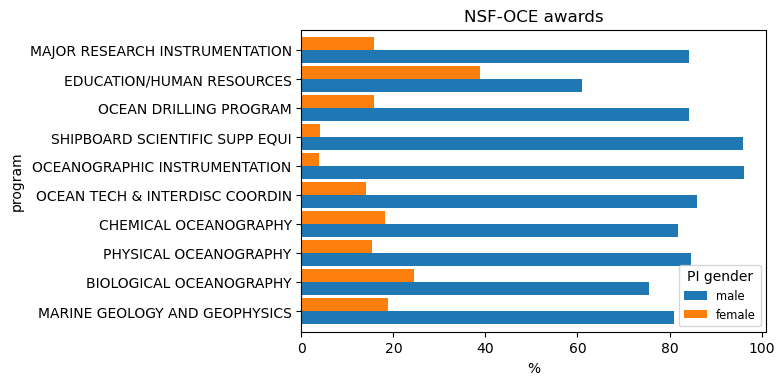

In [28]:
df = awards_top10.groupby(['program','PI_gender'])['Abstract'].count().unstack()
by_program_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
# by_program_pi = by_program_pi.sort_values('male') * 100 # fraction -> percentage
by_program_pi = by_program_pi.reindex(top10_programs.index) * 100 # fraction -> percentage

fig, ax = plt.subplots()
_ = by_program_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(loc='lower right', title='PI gender')
_ = ax.set(title='NSF-OCE awards', xlabel='%')

by_program_pi.style.format('{:.2f}')

co-PI gender percentage in the top 10 NSF-OCE programs. The table and figure show the co-PI gender composition in the top 10 NSF-OCE programs.

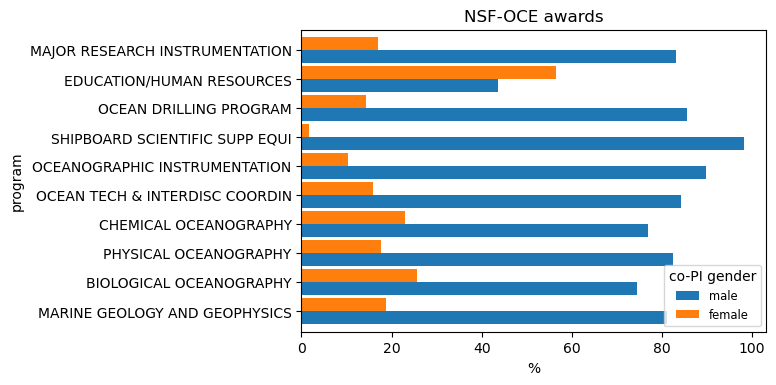

In [29]:
by_program_copi = pd.DataFrame({'female': awards_top10.groupby(['program'])['co-PI_female_frac'].mean()})
by_program_copi['male'] = 1 - by_program_copi.female
by_program_copi.columns.name = 'co-PI gender'
# by_program_copi = by_program_copi.sort_values('male') * 100 # fraction -> percentage
by_program_copi = by_program_copi.reindex(top10_programs.index) * 100 # fraction -> percentage

fig, ax = plt.subplots()
_ = by_program_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(loc='lower right', title='co-PI gender')
_ = ax.set(title='NSF-OCE awards', xlabel='%')

by_program_copi.style.format('{:.2f}')

Combining the 3 bar plots above into one bubble plot. The size of the bubble corresponds to the ratio between the percentage of awards from female and male PIs in each program. A ratio greater than one means female PIs have a larger percentage of awards in that program than male PIs, and vice-versa.

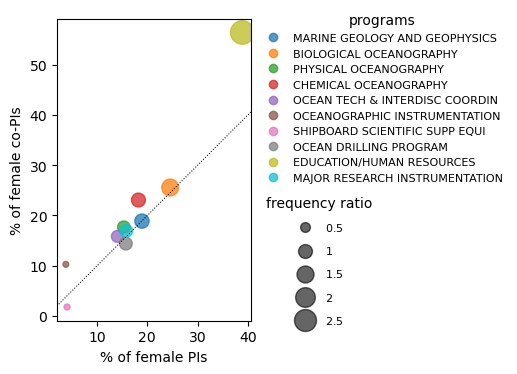

In [30]:
by_prog = pd.DataFrame({'PI': by_program_pi.female,'co-PI':by_program_copi.female,
                        'frequency': df_top10.female/df_top10.male*100, 'color':np.arange(len(by_program_pi))})
n_progs = len(by_prog)
fig, ax = plt.subplots()
sp = ax.scatter(by_prog['PI'], by_prog['co-PI'], c=by_prog['color'], s=by_prog.frequency, cmap=plt.cm.tab10, alpha=0.75)
_ = ax.axis('scaled')
ymin, ymax = ax.get_ylim()
_ = ax.set(xlabel='% of female PIs', ylabel='% of female co-PIs')
_ = ax.plot([0,ymax],[0,ymax],':',color='k',linewidth=0.75)

labels = [p for p in by_prog.index]
handles, foo = sp.legend_elements()
l1 = ax.legend(handles, labels ,loc="upper right", bbox_to_anchor=(2.35, 1.05), title='programs', fontsize=8, frameon=False)
_ = ax.add_artist(l1)

# handles2, labels2 = sp.legend_elements(prop='sizes', num=[100,200,300,400,500], alpha=0.6)
# labels2 = ['$\\mathdefault{5}$','$\\mathdefault{10}$','$\\mathdefault{15}$','$\\mathdefault{20}$','$\\mathdefault{25}$']
handles2, labels2 = sp.legend_elements(prop='sizes', num=[50,100,150,200,250], alpha=0.6)
labels2 = ['$\\mathdefault{0.5}$','$\\mathdefault{1}$','$\\mathdefault{1.5}$','$\\mathdefault{2}$','$\\mathdefault{2.5}$']
# handles2, labels2 = sp.legend_elements(prop='sizes', alpha=0.6)
l2 = ax.legend(handles2, labels2, loc='lower right', bbox_to_anchor=(1.675, -0.05), title='frequency ratio',
               fontsize=8, frameon=False, labelspacing=1)

### Changes in gender composition across top 10 programs (in number of awards)

The figure below shows time series of the annual percentage of female PIs and co-PIs for each of the top 10 NSF-OCE programs (in number of awards). Solid lines represent the linear regression fit and points represent the individual years. If the p-value for the regression slope is not significant ($p<0.05$) the regression line is not plotted. The table shows the linear regressions results.

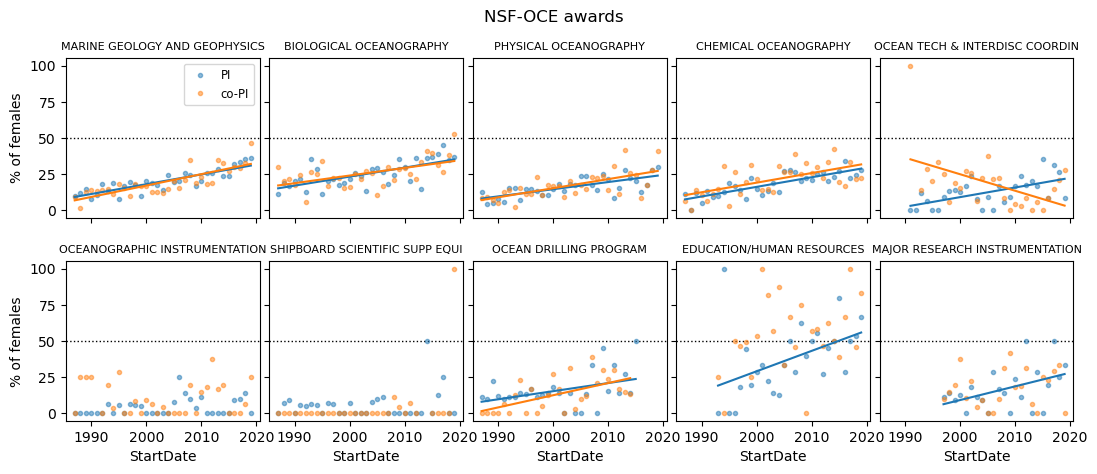

In [31]:
# female & male fraction of PIs
df = awards_top10.groupby(['program',awards_top10.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_program = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_by_program = pd.DataFrame({'female': 
                   awards_top10.groupby(['program',awards_top10.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_program['male'] = 1 - copi_gender_by_program.female

# female percentage of PIs & co-PIs
female_pct_by_program = pd.DataFrame({'PI':pi_gender_by_program['female'] * 100,
                                      'co-PI':copi_gender_by_program['female'] * 100})
nn = 3 # size of moving window (years)
alpha = 0.5

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(13, 4.8))
fig.subplots_adjust(hspace=0.275, wspace=0.05)
params = []
for ax, prog in zip(axs.ravel(), top10_programs.index):
    if prog == 'MARINE GEOLOGY AND GEOPHYSICS':
        legend = True
    else:
        legend=False
    _ = female_pct_by_program.loc[prog].plot(ax=ax, style=['C0.','C1.'],legend=legend, alpha=alpha)

    reg1, X = linreg(female_pct_by_program.loc[prog].index, female_pct_by_program.loc[prog].PI)
    if reg1.pvalues[1]<0.05:
        _ = ax.plot(female_pct_by_program.loc[prog].index, reg1.predict(X), 'C0')
    reg2, X = linreg(female_pct_by_program.loc[prog].dropna().index, female_pct_by_program.loc[prog,'co-PI'].dropna())
    if reg2.pvalues[1]<0.05:
        _ = ax.plot(female_pct_by_program.loc[prog].dropna().index, reg2.predict(X), 'C1')

    params.append([reg1.rsquared,reg1.params[1],reg1.pvalues[1],reg2.rsquared,reg2.params[1],reg2.pvalues[1]])

    _ = ax.set_title(prog, fontsize=8)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(50, x0, x1, linestyles='dotted', linewidth=1, colors='k')
    _ = ax.set_xlim(x0,x1)

for i in range(2):
    _ = axs[i,0].set_ylabel('% of females')

_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=top10_programs.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

The results from the regression below show that the difference in mean female percentage (intercept) between PIs and co-PIs in CHEMICAL OCEANOGRAPHY is not statistically significant.

In [32]:
prog = 'CHEMICAL OCEANOGRAPHY'
# for prog in top10_programs.index:
#     print('\n'+prog)
df1 = pd.DataFrame({'fem_pct':female_pct_by_program.loc[prog,'PI'], 'category':'PI'})
df2 = pd.DataFrame({'fem_pct':female_pct_by_program.loc[prog,'co-PI'], 'category':'co-PI'})
df  = pd.concat([df1,df2]).reset_index()
df.rename(columns={'StartDate': 'year'},inplace=True)
lreg = smf.ols(formula='fem_pct ~ year + category', data=df)
# lreg = smf.ols(formula='fem_pct ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()
#     print(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                fem_pct   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     31.14
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           3.94e-10
Time:                        17:51:17   Log-Likelihood:                -217.42
No. Observations:                  66   AIC:                             440.8
Df Residuals:                      63   BIC:                             447.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1311.4816    172.879     -7.586      0.000   -1656.952    -966.011
category[T.co-PI]     2.9035      1.644      1.767      0.082      -0.381       6.188
year                  0.6639      0.086      7.692      0.000       0.491       0.836
==============================================================================
Omnibus:                        1.000   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                1.028
Skew:                           0.276   Prob(JB):                        0.598
Kurtosis:                       2.739   Cond. No.                     4.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9,8))
# for ax, prog in zip(axs.ravel(),
#                     ['MARINE GEOLOGY AND GEOPHYSICS','BIOLOGICAL OCEANOGRAPHY', 'PHYSICAL OCEANOGRAPHY', 'CHEMICAL OCEANOGRAPHY']):
#     df = female_frac_by_program.loc[prog]
#     _ = sns.regplot(df.index, df.PI, ax=ax)
#     _ = sns.regplot(df.index, df['co-PI'], ax=ax)
#     _ = ax.set_title(prog)

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female percentage/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the top 10 NSF-OCE programs. The table shows the sum of the anomalies for each program which is a metric of how each program is performing relative to the academic workforce. Positive and negative values indicate that the program is overperforming and underperforming female representation in the academic workforce, respectively.

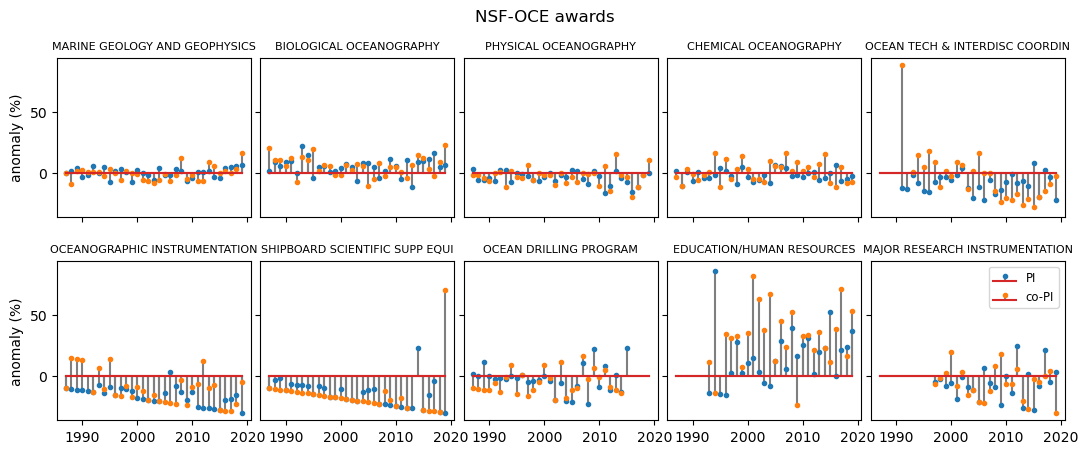

In [34]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(13, 4.8))
fig.subplots_adjust(hspace=0.275, wspace=0.05)
params = []
for ax, prog in zip(axs.ravel(), top10_programs.index):
    if prog == 'MARINE GEOLOGY AND GEOPHYSICS':
        legend = True
    else:
        legend=False
    anom = female_pct_by_program.loc[prog] - df_ref
    _ = ax.stem(anom.index.values, anom.PI, markerfmt='C0.', linefmt='C7', label='PI')
    _ = ax.stem(anom.index.values, anom['co-PI'], markerfmt='C1.', linefmt='C7', label='co-PI')
#     _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
#     _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
#     _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
#     _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)   
    _ = ax.set_title(prog, fontsize=8)
#     x0, x1 = ax.get_xlim()
#     _ = ax.hlines(0, x0, x1, linestyles='dotted', linewidth=1, colors='k', alpha=0.5)
#     _ = ax.set_xlim(x0,x1)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(2):
    _ = axs[i,0].set_ylabel('anomaly (%)')

_ = ax.legend(loc='best')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

df_anom = pd.DataFrame(data=params, index=top10_programs.index, columns=['PI', 'co-PI'])
df_anom.columns.name = 'total sum'
df_anom.style.format('{:.2f}')

## Academic organizations

### Top 10 academic organizations in number of awards

In [35]:
# shorten some organization names
awards.loc[awards.Organization == 'University of Miami Rosenstiel School of Marine&Atmospheric Sci',
           'Organization'] = 'University of Miami RSMAS'
awards.loc[awards.Organization == 'University of California-San Diego Scripps Inst of Oceanography',
           'Organization'] = 'UCSD Scripps Institution of Oceanography'

The table and histogram below show the top 10 academic organizations in number of awards for the period 1987-2019.

number of awards  \
Organization                                                 
Woods Hole Oceanographic Institution                  1600   
UCSD Scripps Institution of Oceanography               807   
Columbia University                                    602   
University of Washington                               598   
Oregon State University                                569   
University of Hawaii                                   502   
University of Miami RSMAS                              323   
University of Rhode Island                             299   
University of Delaware                                 198   
University of California-Santa Barbara                 181   

                                          percentage of total  \
Organization                                                    
Woods Hole Oceanographic Institution                13.897333   
UCSD Scripps Institution of Oceanography             7.009468   
Columbia University                                  5.228872   
University of Washington                             5.194128   
Oregon State University                              4.942239   
University of Hawaii                                 4.360288   
University of Miami RSMAS                            2.805524   
University of Rhode Island                           2.597064   
University of Delaware                               1.719795   
University of California-Santa Barbara               1.572136   

                                          cum percentage of total  
Organization                                                       
Woods Hole Oceanographic Institution                    13.897333  
UCSD Scripps Institution of Oceanography                20.906801  
Columbia University                                     26.135673  
University of Washington                                31.329801  
Oregon State University                                 36.272040  
University of Hawaii                                    40.632329  
University of Miami RSMAS                               43.437853  
University of Rhode Island                              46.034917  
University of Delaware                                  47.754712  
University of California-Santa Barbara                  49.326848

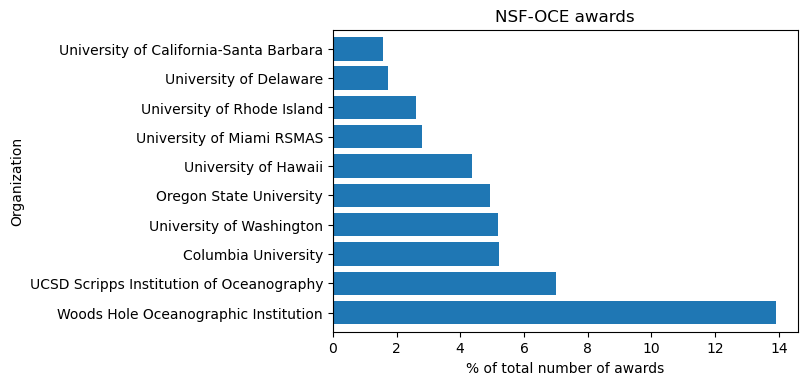

In [36]:
top10_orgs = pd.DataFrame(
    {'number of awards':
     awards.groupby('Organization')['Abstract'].count().sort_values(ascending=False)[:10]})
top10_orgs['percentage of total'] = top10_orgs['number of awards']/len(awards)*100
top10_orgs['cum percentage of total'] = top10_orgs['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = top10_orgs['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total number of awards')

top10_orgs

Boxplot of award size by academic organization.

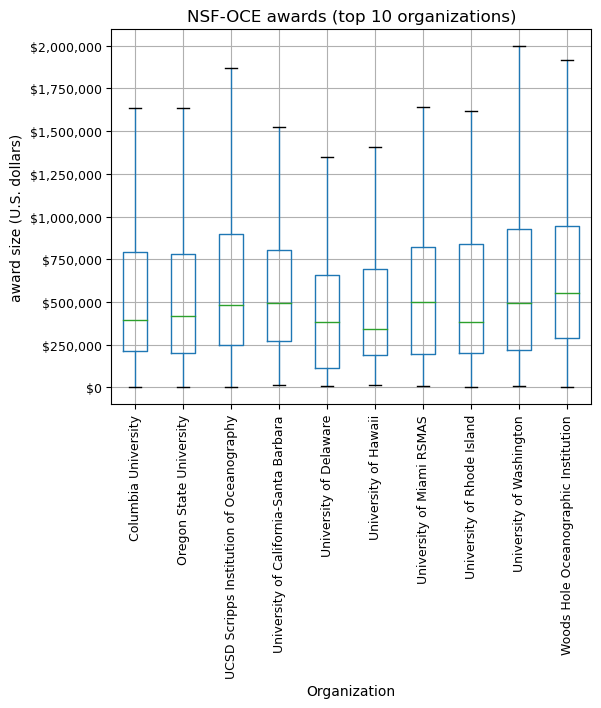

In [37]:
df = awards[awards.Organization.isin(top10_orgs.index)]
fig, ax = plt.subplots(figsize=(6, 5))
_ = df.boxplot('tot_amount_adjusted', by='Organization', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards (top 10 organizations)', ylabel='award size (U.S. dollars)')
_ = fig.suptitle('')

In [38]:
# fig, ax = plt.subplots(figsize=(6, 5))
# _ = df.boxplot('evenness', by='Organization', showfliers=False, showmeans=True,
#                rot=90, fontsize=9, ax=ax)
# _ = ax.set(title='NSF-OCE awards (top 10 organizations)', ylabel='award interdisciplinarity')
# _ = fig.suptitle('')

The figure below shows the time series of the number of awards and the percentage of awards per year for each of the top 10 organizations.

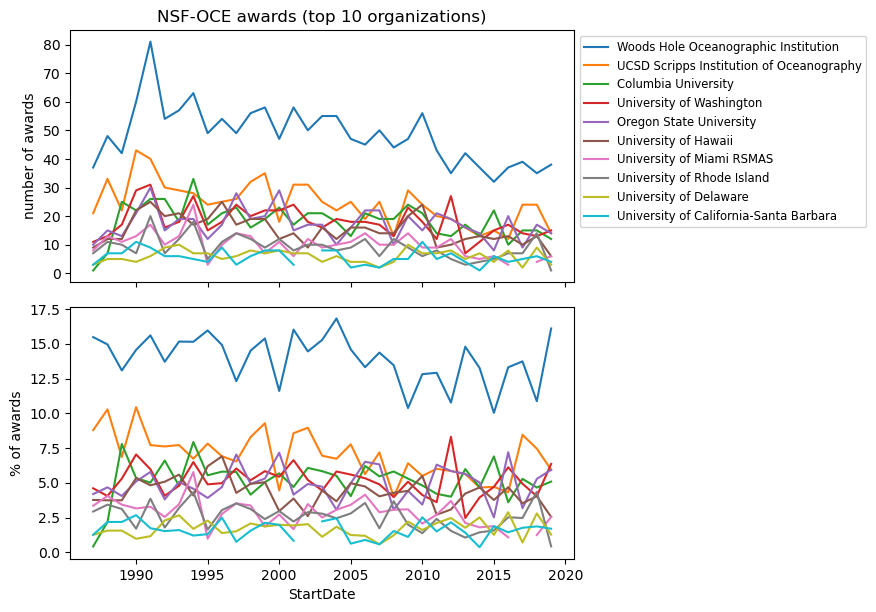

In [39]:
org_year = awards.groupby([awards.StartDate.dt.year,'Organization'])['Abstract'].count().unstack()
org_year = org_year[top10_orgs.index]
org_year_pct = org_year.divide(num_awards_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.5,7))
fig.subplots_adjust(hspace=0.1)
_ = org_year.plot(ax=axs[0]).legend(bbox_to_anchor=(1, 1))
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards (top 10 organizations)')
_ = org_year_pct.plot(ax=axs[1], legend=False)
_ = axs[1].set_ylabel('% of awards')

### Top 10 academic organizations in total amount awarded

The table and histogram below show the top 10 academic organizations in total amount awarded for the period 1987-2019.

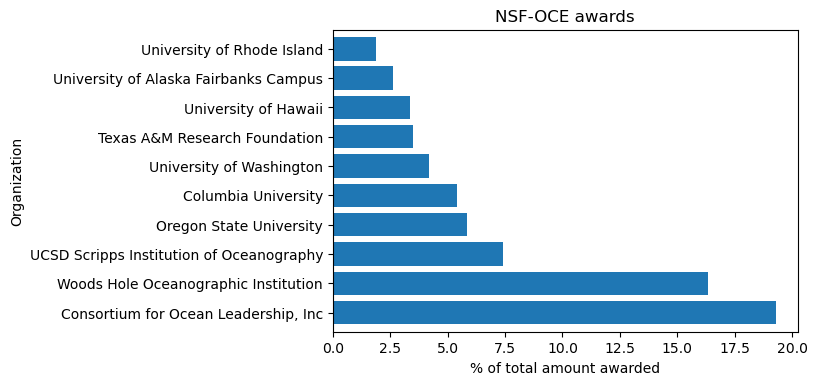

In [40]:
top10_orgs_amount = pd.DataFrame(
    {'amount awarded':
     awards.groupby('Organization')['tot_amount_adjusted'].sum().sort_values(ascending=False)[:10]})
top10_orgs_amount['percentage of total'] = (top10_orgs_amount['amount awarded']/
                                     awards.tot_amount_adjusted.sum()*100)
top10_orgs_amount['cum percentage of total'] = top10_orgs_amount['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = top10_orgs_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total amount awarded')

top10_orgs_amount.style.format('${0:,.2f}', subset='amount awarded')

The figure below shows the time series of the amount awarded and percentage of the amount awarded per year for each of the top 10 organizations.

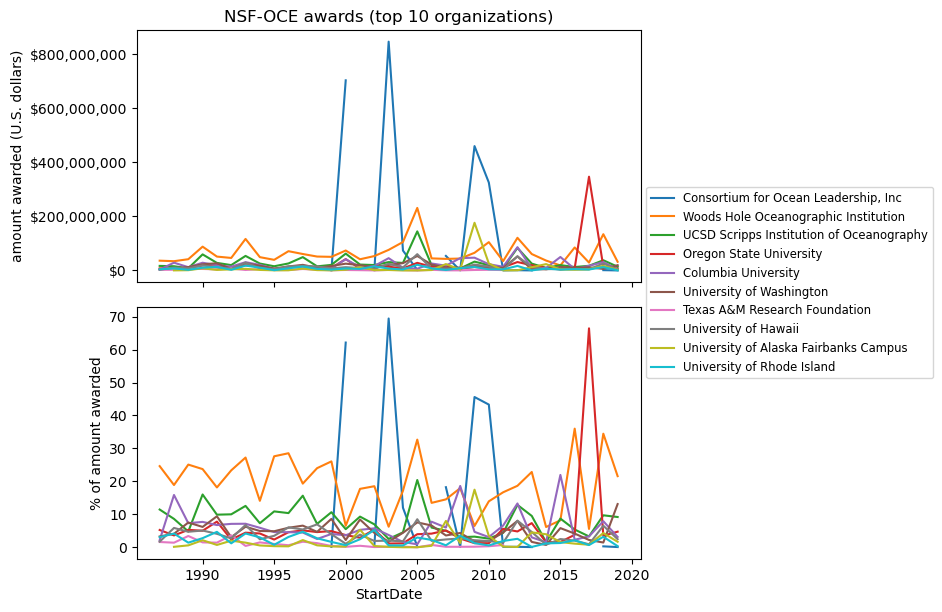

In [41]:
org_year_amount = awards.groupby(
    [awards.StartDate.dt.year,'Organization'])['tot_amount_adjusted'].sum().unstack()
org_year_amount = org_year_amount[top10_orgs_amount.index[0:]]
org_year_amount_pct = org_year_amount.divide(amount_per_year, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.5,7))
fig.subplots_adjust(hspace=0.1)
_ = org_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards (top 10 organizations)')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = org_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

### Gender composition across top 10 organizations (in number of awards)

PI gender percentage in the top 10 organizations. The table and figure show the PI gender composition in the top 10 organizations.

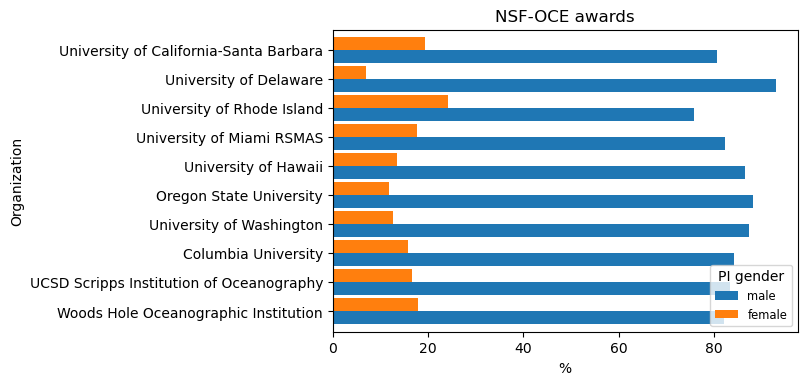

In [42]:
df_org = awards[awards.Organization.isin(top10_orgs.index)]

df = df_org.groupby(['Organization','PI_gender'])['Abstract'].count().unstack()
by_org_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
# by_org_pi = by_org_pi.sort_values('male') * 100 # fraction -> percentage
by_org_pi = by_org_pi.reindex(top10_orgs.index) * 100 # fraction -> percentage

fig, ax = plt.subplots()
_ = by_org_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(title='PI gender',loc='lower right',bbox_to_anchor=(1, 0))
_ = ax.set(title='NSF-OCE awards', xlabel='%')

by_org_pi.style.format('{:.2f}')

co-PI gender percentage in the top 10 organizations. The table and figure show the co-PI gender composition in the top 10 organizations.

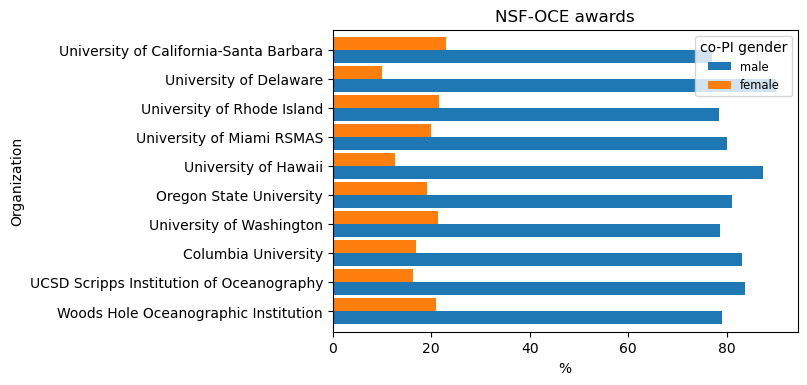

In [43]:
by_org_copi = pd.DataFrame({'female': df_org.groupby(['Organization'])['co-PI_female_frac'].mean()})
by_org_copi['male'] = 1 - by_org_copi.female
# by_org_copi = by_org_copi.sort_values('male') * 100 # fraction -> percentage
by_org_copi = by_org_copi.reindex(top10_orgs.index) * 100 # fraction -> percentage
by_org_copi.columns.name = 'co-PI gender'

fig, ax = plt.subplots()
_ = by_org_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(title='co-PI gender',loc='upper right')
_ = ax.set(title='NSF-OCE awards', xlabel='%')

by_org_copi.style.format('{:.2f}')

Combining the 2 bar plots above into one bubble plot.

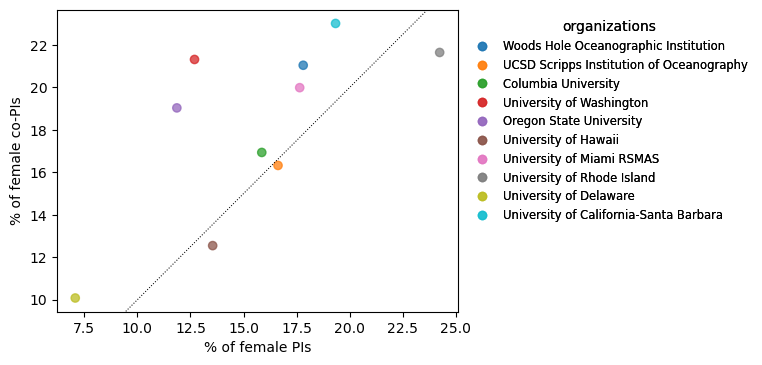

In [44]:
by_org = pd.DataFrame({'PI': by_org_pi.female,'co-PI':by_org_copi.female,'color':np.arange(len(by_org_pi))})
by_org

n_orgss = len(by_org)
fig, ax = plt.subplots()
sp = ax.scatter(by_org['PI'], by_org['co-PI'], c=by_prog['color'], cmap=plt.cm.tab10, alpha=0.75)
_ = ax.axis('scaled')
ymin, ymax = ax.get_ylim()
_ = ax.set(xlabel='% of female PIs', ylabel='% of female co-PIs')
_ = ax.plot([0,ymax],[0,ymax],':',color='k',linewidth=0.75)

labels = [p for p in by_org.index]
handles, foo = sp.legend_elements()
l1 = ax.legend(handles, labels ,loc="upper right", bbox_to_anchor=(1.75, 1), title='organizations', frameon=False)
_ = ax.add_artist(l1)

### Changes in gender composition across top 10 organizations (in number of awards)

The figure below shows time series of the annual percentage of female PIs and co-PIs for each of the top 10 academic organizations (in number of awards). Solid lines represent the linear regression fit and points represent the individual years. If the p-value for the regression slope is not significant ($p<0.05$) the regression line is not plotted. The table shows the linear regressions results.

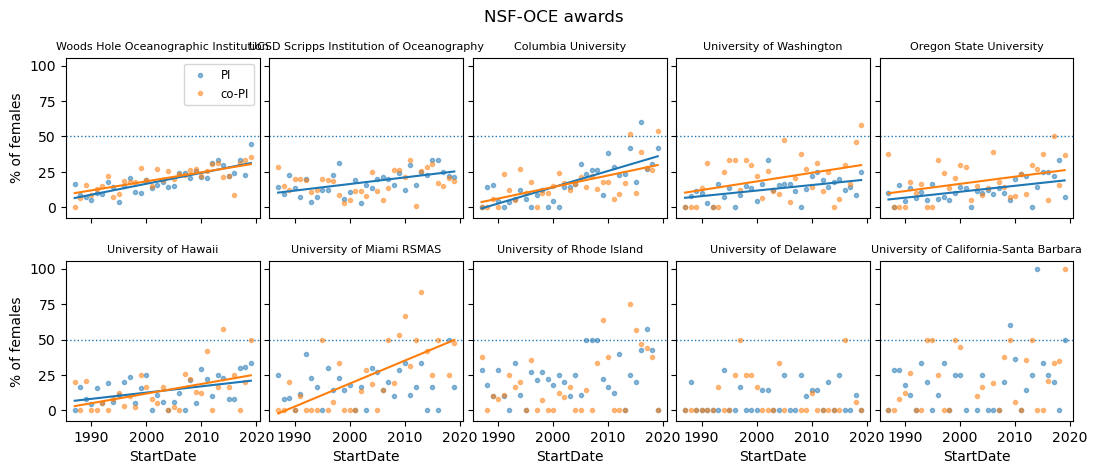

In [45]:
# female & male fraction of PIs
df = df_org.groupby(['Organization',df_org.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_org = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_by_org = pd.DataFrame({'female': 
                   df_org.groupby(['Organization',df_org.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_org['male'] = 1 - copi_gender_by_org.female

female_pct_by_org = pd.DataFrame({'PI':pi_gender_by_org['female'] * 100, 'co-PI': copi_gender_by_org['female'] * 100})

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(13, 4.8))
fig.subplots_adjust(hspace=0.275, wspace=0.05)
params = []
for ax, org in zip(axs.ravel(), top10_orgs.index):
    if org == 'Woods Hole Oceanographic Institution':
        legend = True
    else:
        legend=False
    _ = female_pct_by_org.loc[org].plot(ax=ax, style=['C0.','C1.'], legend=legend, alpha=alpha)

    reg1, X = linreg(female_pct_by_org.loc[org].index, female_pct_by_org.loc[org].PI)
    if reg1.pvalues[1]<0.05:
        _ = ax.plot(female_pct_by_org.loc[org].index, reg1.predict(X), 'C0')
    reg2, X = linreg(female_pct_by_org.loc[org].dropna().index, female_pct_by_org.loc[org,'co-PI'].dropna())
    if reg2.pvalues[1]<0.05:
        _ = ax.plot(female_pct_by_org.loc[org].dropna().index, reg2.predict(X), 'C1')
    params.append([reg1.rsquared,reg1.params[1],reg1.pvalues[1],reg2.rsquared,reg2.params[1],reg2.pvalues[1]])

    _ = ax.set_title(org, fontsize=8)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(50, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    

for i in range(2):
    _ = axs[i,0].set_ylabel('% of females')

_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=top10_orgs.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female percentage/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the top 10 academic organizations. The table shows the sum of the anomalies for each organization which is a metric of how each organization is performing relative to the academic workforce. Positive and negative values indicate that the organization is overperforming and underperforming female representation in the academic workforce, respectively.

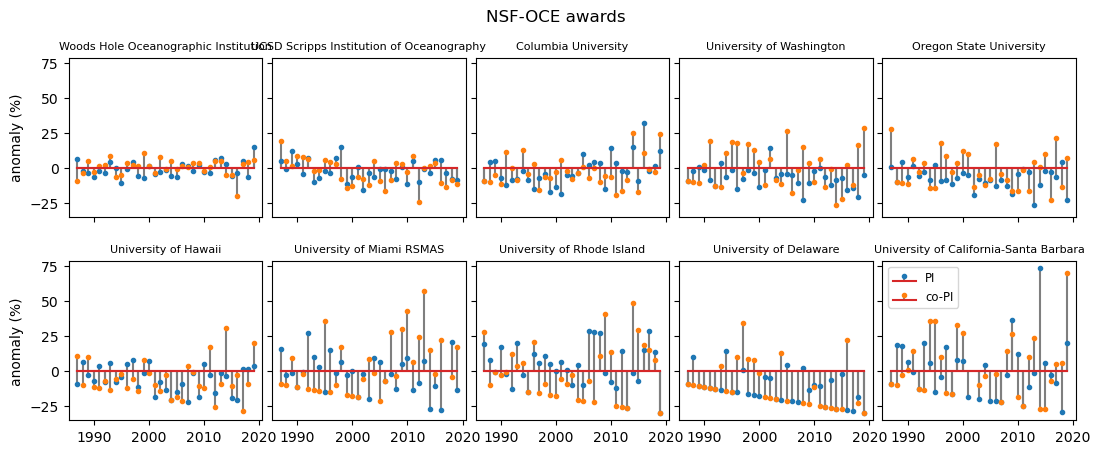

In [46]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(13, 4.8))
fig.subplots_adjust(hspace=0.275, wspace=0.05)
params = []
for ax, org in zip(axs.ravel(), top10_orgs.index):
    if prog == 'Woods Hole Oceanographic Institution':
        legend = True
    else:
        legend=False
    anom = female_pct_by_org.loc[org] - df_ref
    _ = ax.stem(anom.index.values, anom.PI, markerfmt='C0.', linefmt='C7', label='PI')
    _ = ax.stem(anom.index.values, anom['co-PI'], markerfmt='C1.', linefmt='C7', label='co-PI')
#     _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
#     _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
#     _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
#     _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)       
    _ = ax.set_title(org, fontsize=8)
#     x0, x1 = ax.get_xlim()
#     _ = ax.hlines(0, x0, x1, linestyles='dotted', linewidth=1, colors='k', alpha=0.5)
#     _ = ax.set_xlim(x0,x1)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(2):
    _ = axs[i,0].set_ylabel('anomaly (%)')

_ = ax.legend(loc='best')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

df_anom = pd.DataFrame(data=params, index=top10_orgs.index, columns=['PI', 'co-PI'])
df_anom.columns.name = 'total sum'
df_anom.style.format('{:.2f}')

## Research topics

Similarly to what was done in [Lima & Rheuban, 2018](https://tos.org/oceanography/article/topics-and-trends-in-nsf-ocean-sciences-awards), we applied non-negative matrix factorization (NMF) to the NSF-OCE abstracts to extract 22 research topics.

The table and histogram below show the number of awards and relative frequency of awards per research topic for the period 1987-2019.

number of awards  percentage of total  \
climate change record 10                           861             7.478503   
microbial phytoplankton cell 18                    815             7.078954   
workshop science international  8                  750             6.514375   
sensor instrument measurement 12                   696             6.045340   
ridge mantle melt  4                               690             5.993225   
population larval specie  6                        685             5.949796   
wave internal turbulence  5                        636             5.524190   
sediment core margin 20                            634             5.506818   
seismic earthquake plate 19                        604             5.246243   
instrumentation university shared  3               600             5.211500   
circulation woce atlantic 13                       584             5.072527   
shelf coastal transport 22                         559             4.855381   
trace element isotope 14                           518             4.499262   
hydrothermal vent fluid 11                         483             4.195258   
carbon organic matter  9                           402             3.491705   
vessel ship operate 16                             381             3.309303   
student reu science 17                             348             3.022670   
nitrogen fixation n2 21                            333             2.892383   
coral reef bleaching  7                            325             2.822896   
equipment scientific shipboard  2                  288             2.501520   
iron fe phytoplankton 15                           191             1.658994   
flux sea gas  1                                    130             1.129158   

                                      cum percentage of total  
climate change record 10                             7.478503  
microbial phytoplankton cell 18                     14.557457  
workshop science international  8                   21.071832  
sensor instrument measurement 12                    27.117172  
ridge mantle melt  4                                33.110397  
population larval specie  6                         39.060193  
wave internal turbulence  5                         44.584383  
sediment core margin 20                             50.091201  
seismic earthquake plate 19                         55.337445  
instrumentation university shared  3                60.548945  
circulation woce atlantic 13                        65.621471  
shelf coastal transport 22                          70.476852  
trace element isotope 14                            74.976114  
hydrothermal vent fluid 11                          79.171371  
carbon organic matter  9                            82.663077  
vessel ship operate 16                              85.972379  
student reu science 17                              88.995049  
nitrogen fixation n2 21                             91.887432  
coral reef bleaching  7                             94.710327  
equipment scientific shipboard  2                   97.211847  
iron fe phytoplankton 15                            98.870842  
flux sea gas  1                                    100.000000

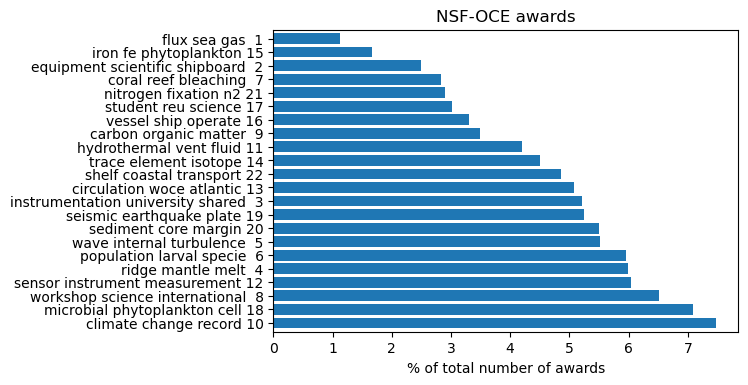

In [47]:
res_topics = pd.DataFrame({'number of awards':awards.groupby('topic')['Abstract'].count().sort_values(ascending=False)})
res_topics.index = topic_names[res_topics.index.values - 1]
res_topics['percentage of total'] = res_topics['number of awards'] / len(awards) * 100
res_topics['cum percentage of total'] = res_topics['percentage of total'].cumsum() 

fig, ax = plt.subplots()
_ = res_topics['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total number of awards')

res_topics

The table and histogram below show the total amount awarded per research topic for the period 1987-2019.

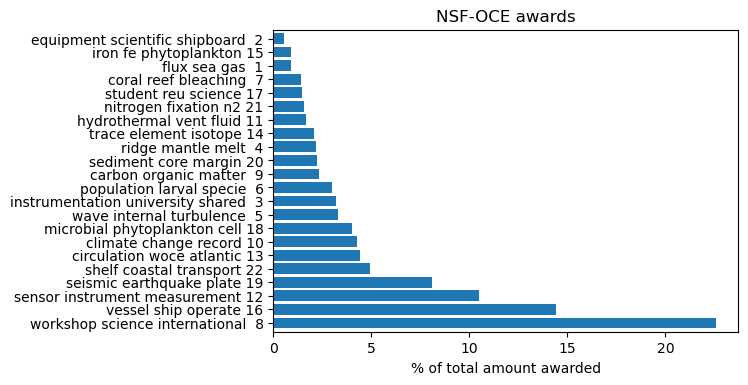

In [48]:
res_topics_amount = pd.DataFrame({'amount awarded':awards.groupby('topic')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
res_topics_amount.index = topic_names[res_topics_amount.index.values - 1]
res_topics_amount['percentage of total'] = res_topics_amount['amount awarded'] / awards.tot_amount_adjusted.sum() * 100
res_topics_amount['cum percentage of total'] = res_topics_amount['percentage of total'].cumsum() 

fig, ax = plt.subplots()
_ = res_topics_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total amount awarded')

res_topics_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by research topic.

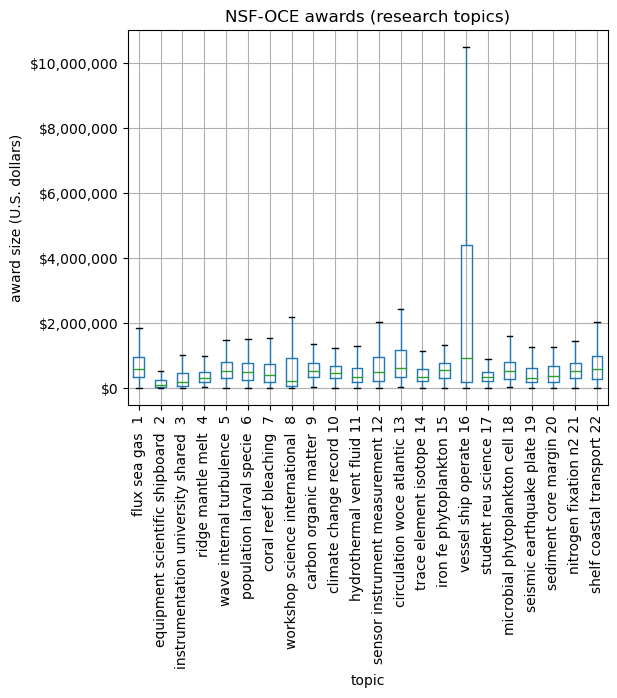

In [49]:
fig, ax = plt.subplots(figsize=(6, 5))
_ = awards.boxplot('tot_amount_adjusted', by='topic', showfliers=False, rot=90, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards (research topics)', ylabel='award size (U.S. dollars)', xticklabels=topic_names)
_ = fig.suptitle('')

Boxplot of award interdisciplinarity by research topic.

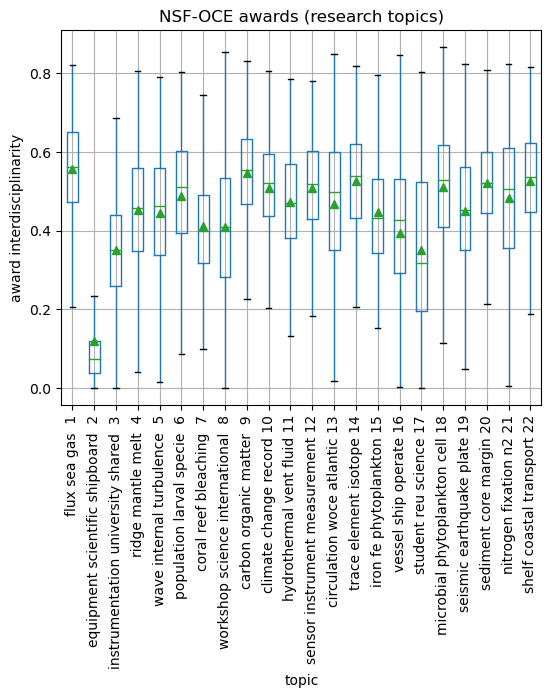

In [50]:
fig, ax = plt.subplots(figsize=(6, 5))
_ = awards.boxplot('evenness', by='topic', showfliers=False, showmeans=True, rot=90, ax=ax)
_ = ax.set(title='NSF-OCE awards (research topics)', ylabel='award interdisciplinarity', xticklabels=topic_names)
_ = fig.suptitle('')


### Frequency distribution of topics by PI gender

The table and figure below show the relative frequency distribution of different topics by PI gender. The table and figure show how the awards from each gender (PI) are distributed across the different topics.

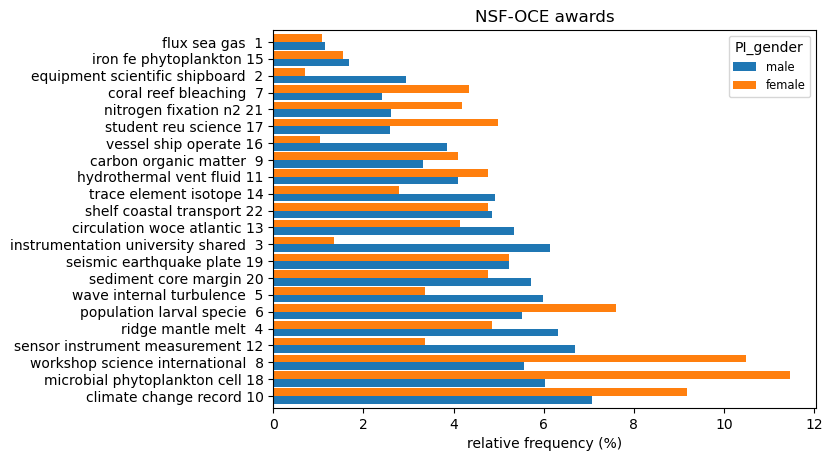

In [51]:
df_topics = awards.groupby(['topic','PI_gender'])['Abstract'].count().unstack()
df_topics = df_topics/df_topics.sum() * 100
df_topics.index = topic_names
df_topics.index.name = 'topic'
# df_topics = df_topics.sort_values('female', ascending=False)
df_topics = df_topics.reindex(res_topics.index)

fig, ax = plt.subplots(figsize=(7,5))
_ = df_topics[['male','female']].dropna().plot(kind='barh', width=0.9, ax=ax)
_ = ax.set(title='NSF-OCE awards', xlabel='relative frequency (%)')

df_topics.style.format('{:.2f}')

### Gender composition across research topics

PI gender percentage across research topics. Gender composition of PIs in the different research topics.

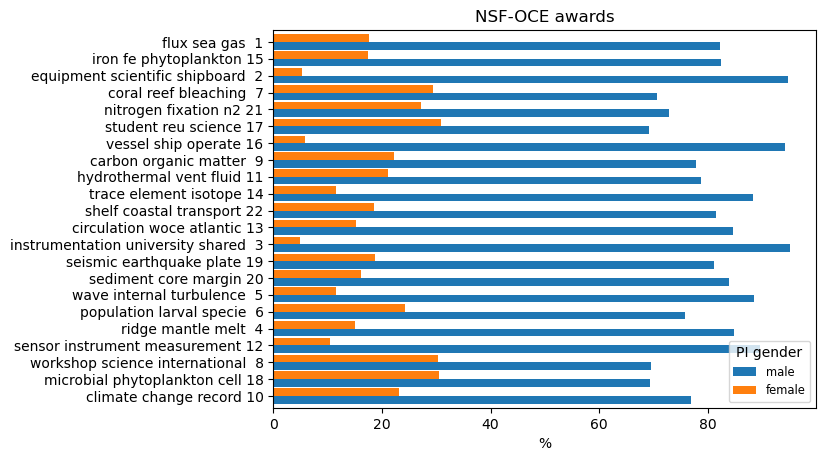

In [52]:
df = awards.groupby(['topic','PI_gender'])['Abstract'].count().unstack()
by_topic_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
by_topic_pi.index = topic_names
by_topic_pi.index.name = 'topic'
# by_topic_pi = by_topic_pi.sort_values('male') * 100 # fraction -> percentage
by_topic_pi = by_topic_pi.reindex(res_topics.index) * 100 # fraction -> percentage

fig, ax = plt.subplots(figsize=(7,5))
_ = by_topic_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(title='PI gender', loc='lower right', bbox_to_anchor=(1, 0))
_ = ax.set(title='NSF-OCE awards', xlabel='%')

by_topic_pi.style.format('{:.2f}')

co-PI gender percentage across research topics. Gender composition of co-PIs in the different research topics.

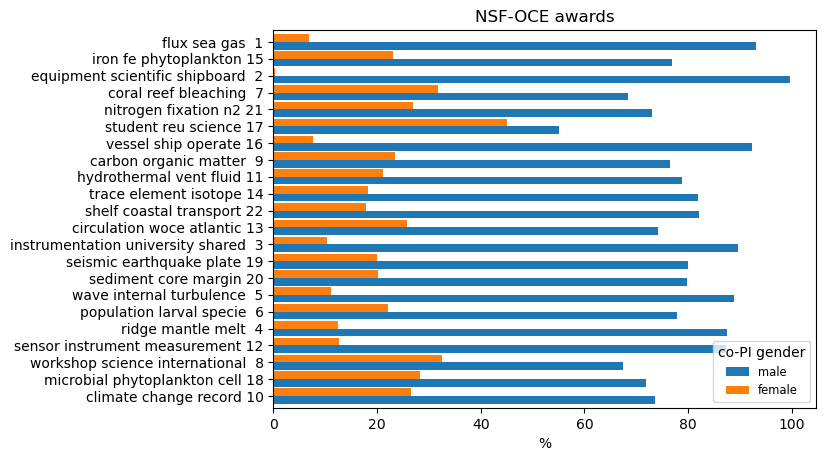

In [53]:
by_topic_copi = pd.DataFrame({'female':awards.groupby(['topic'])['co-PI_female_frac'].mean()})
by_topic_copi['male'] = 1 - by_topic_copi.female
by_topic_copi.index = topic_names
by_topic_copi.index.name = 'topic'
by_topic_copi.columns.name = 'co-PI gender'
# by_topic_copi = by_topic_copi.sort_values('male') * 100 # fraction -> percentage
by_topic_copi = by_topic_copi.reindex(res_topics.index) * 100 # fraction -> percentage

fig, ax = plt.subplots(figsize=(7,5))
_ = by_topic_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(title='co-PI gender',loc='lower right',bbox_to_anchor=(1, 0))
_ = ax.set(title='NSF-OCE awards', xlabel='%')

by_topic_copi.style.format('{:.2f}')

Combining the 3 bar plots above into one bubble plot. The size of the bubble corresponds to the ratio between the percentage of awards from female and male PIs in each topic. A ratio greater than one means female PIs have a larger percentage of awards in that topic than male PIs, and vice-versa.

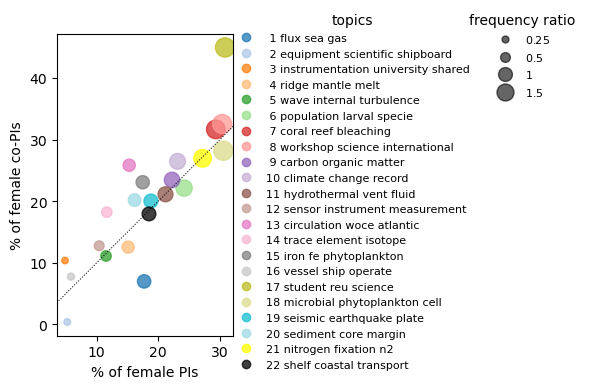

In [54]:
from matplotlib.colors import ListedColormap

by_topic = pd.DataFrame({'PI': by_topic_pi.female,'co-PI':by_topic_copi.female,
                         'frequency': df_topics.female/df_topics.male * 100})
by_topic = by_topic.loc[topic_names,:] # reorder index (topics)
by_topic['color'] = np.arange(len(by_topic_pi))

n_topics = len(by_topic)
tab20 = plt.cm.get_cmap('tab20')
newcolors = tab20.colors + ((1,1,0.0),) + ((0,0,0),)
tab22 = ListedColormap(newcolors,'tab22')

fig, ax = plt.subplots()
sp = ax.scatter(by_topic['PI'], by_topic['co-PI'], c=by_topic['color'], s=by_topic.frequency, cmap=tab22, alpha=0.75)
_ = ax.axis('scaled')
ymin, ymax = ax.get_ylim()
_ = ax.set(xlabel='% of female PIs', ylabel='% of female co-PIs')
_ = ax.plot([0,ymax],[0,ymax],':',color='k',linewidth=0.75)

labels = [p for p in topic_names_r]
handles, foo = sp.legend_elements(num=n_topics)
l1 = ax.legend(handles, labels ,loc="upper right", bbox_to_anchor=(2.4, 1.1), title='topics', fontsize=8, frameon=False)
_ = ax.add_artist(l1)

# handles2, labels2 = sp.legend_elements(prop='sizes', num=[40,80,120,160,200], alpha=0.6)
# labels2 = ['$\\mathdefault{2}$','$\\mathdefault{4}$','$\\mathdefault{6}$','$\\mathdefault{8}$','$\\mathdefault{10}$']
handles2, labels2 = sp.legend_elements(prop='sizes', num=[25,50,100,150], alpha=0.6)
labels2 = ['$\\mathdefault{0.25}$','$\\mathdefault{0.5}$','$\\mathdefault{1}$','$\\mathdefault{1.5}$']
l2 = ax.legend(handles2, labels2, loc='upper right', bbox_to_anchor=(3, 1.1), title='frequency ratio', fontsize=8, frameon=False)

### Changes in gender composition across research topics

The figure below shows time series of the annual percentage of female PIs and co-PIs for each of the identified research topics. Solid lines represent the linear regression fit and points represent the individual years. If the p-value for the regression slope is not significant ($p<0.05$) the regression line is not plotted. The table shows the linear regressions results.

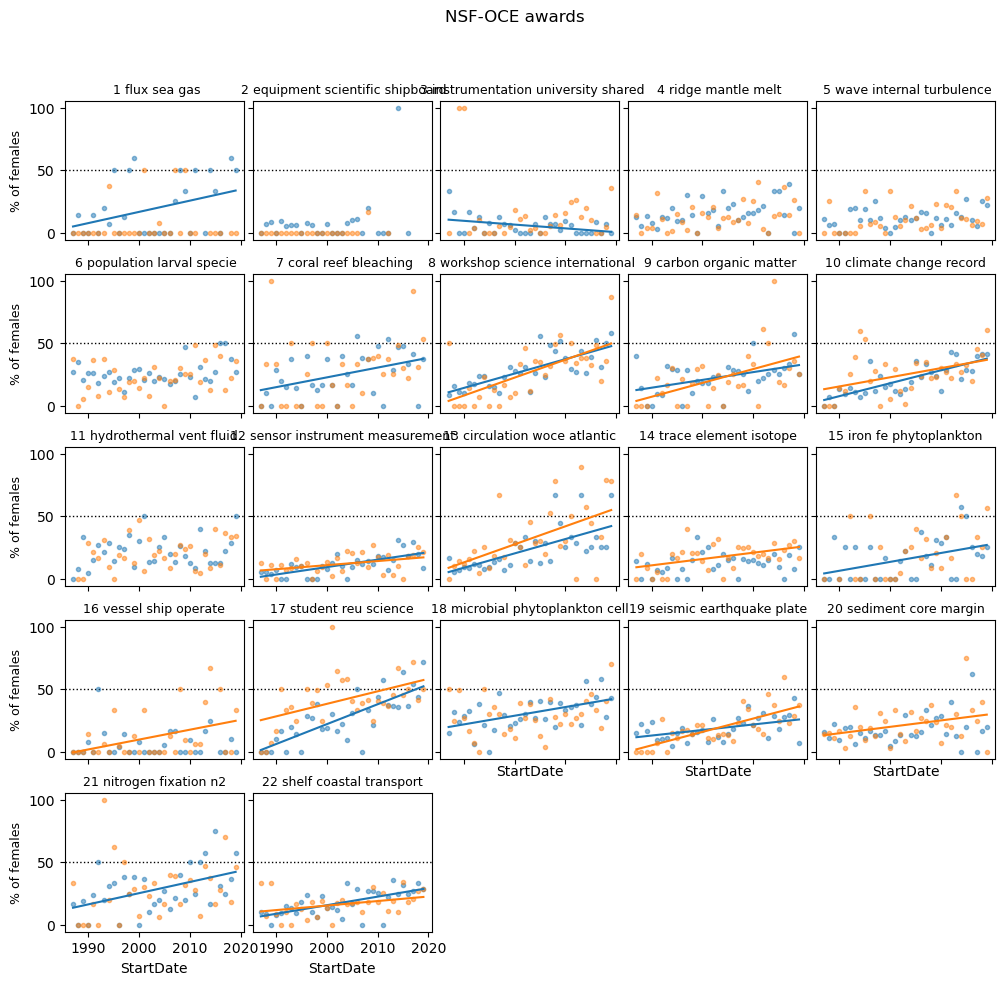

In [55]:
df = awards.groupby(['topic',awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_topic = df.fillna(0).divide(df.sum(axis=1), axis=0)

copi_gender_by_topic = pd.DataFrame(
    {'female':awards.groupby(['topic', awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_topic['male'] = 1 - copi_gender_by_topic.female
copi_gender_by_topic

female_pct_by_topic = pd.DataFrame({'PI':pi_gender_by_topic.female * 100, 'co-PI':copi_gender_by_topic.female * 100})

fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(12,11))
fig.subplots_adjust(hspace=0.25, wspace=0.05)
fig.delaxes(axs[4,4])
fig.delaxes(axs[4,3])
fig.delaxes(axs[4,2])
params = []
for ax, t in zip(axs.ravel(), range(1,23)):
    if t == 2:
        legend = True
    else:
        legend=False    
    _ = female_pct_by_topic.loc[t].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=alpha)

    reg1, X = linreg(female_pct_by_topic.loc[t].index, female_pct_by_topic.loc[t].PI)
    if reg1.pvalues[1]<0.05:
        _ = ax.plot(female_pct_by_topic.loc[t].index, reg1.predict(X), 'C0')
    reg2, X = linreg(female_pct_by_topic.loc[t].dropna().index, female_pct_by_topic.loc[t,'co-PI'].dropna())
    if reg2.pvalues[1]<0.05:
        _ = ax.plot(female_pct_by_topic.loc[t].dropna().index, reg2.predict(X), 'C1')
    params.append([reg1.rsquared,reg1.params[1],reg1.pvalues[1],reg2.rsquared,reg2.params[1],reg2.pvalues[1]])

    _ = ax.set_title(topic_names_r[t-1], fontsize=9)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(50, x0, x1, linestyles='dotted', linewidth=1, color='k')
    _ = ax.set_xlim(x0,x1)

for i in range(5):
    _ = axs[i,0].set_ylabel('% of females', fontsize=9)

_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=topic_names_r,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female percentage/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the identified research topic. The table shows the sum of the anomalies for each topic which is a metric of how each topic is performing relative to the academic workforce. Positive and negative values indicate that the topic is overperforming and underperforming female representation in the academic workforce, respectively.

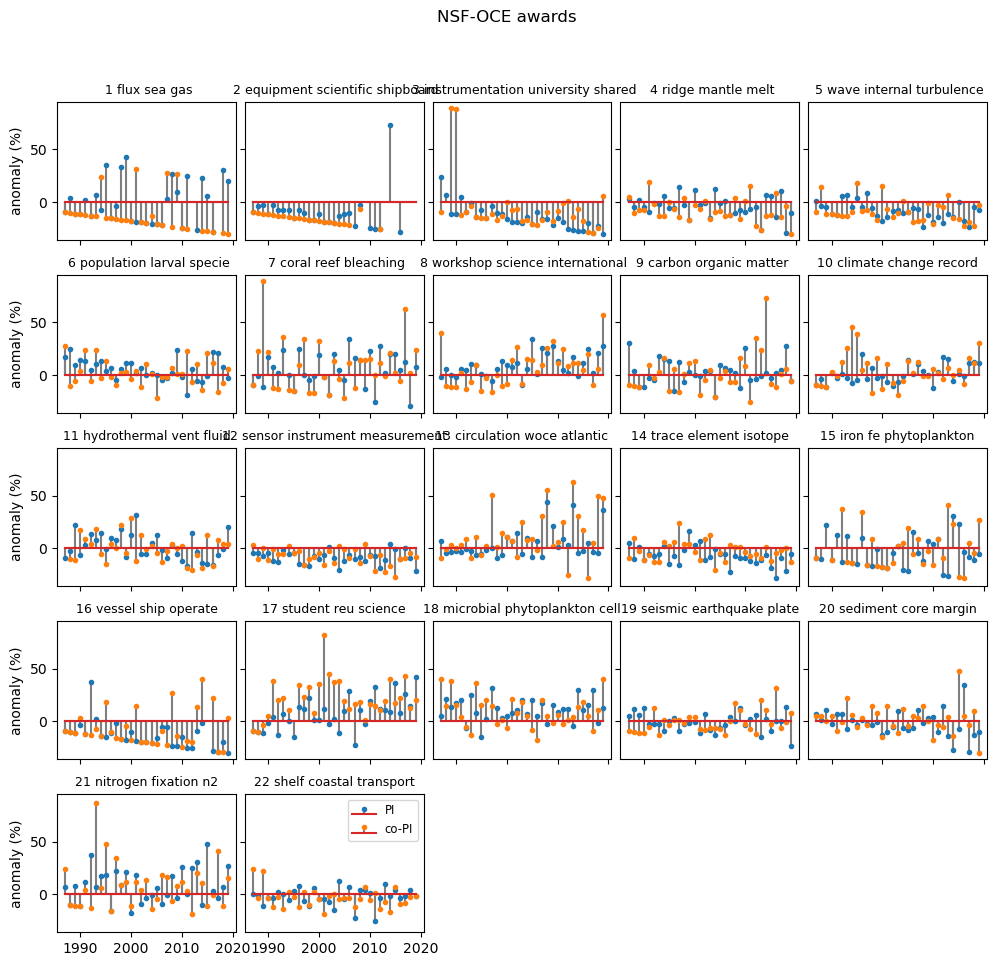

In [56]:
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(12,11))
fig.subplots_adjust(hspace=0.25, wspace=0.05)
fig.delaxes(axs[4,4])
fig.delaxes(axs[4,3])
fig.delaxes(axs[4,2])
params = []
for ax, t in zip(axs.ravel(), range(1,23)):
    if t == 2:
        legend = True
    else:
        legend=False
    anom = female_pct_by_topic.loc[t] - df_ref
    _ = ax.stem(anom.index.values, anom.PI, markerfmt='C0.', linefmt='C7', label='PI')
    _ = ax.stem(anom.index.values, anom['co-PI'], markerfmt='C1.', linefmt='C7', label='co-PI')
#     _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
#     _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
#     _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
#     _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)           
    _ = ax.set_title(topic_names_r[t-1], fontsize=9)
#     x0, x1 = ax.get_xlim()
#     _ = ax.hlines(0, x0, x1, linestyles='dotted', linewidth=1, colors='k', alpha=0.5)
#     _ = ax.set_xlim(x0,x1)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(5):
    _ = axs[i,0].set_ylabel('anomaly (%)')

_ = ax.legend(loc='best')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

df_anom = pd.DataFrame(data=params, index=topic_names_r, columns=['PI', 'co-PI'])
df_anom.columns.name = 'total sum'
df_anom.index.name = 'topics'
df_anom.style.format('{:.2f}')

## Award types

Types of awards and initiatives identified in the data include:

- Collaborative Research
- EAGER: EArly-concept Grant For Exploratory Research
- RAPID: Rapid Response Research
- REU: Research Experience for Undergraduates
- RUI: Research in Undergraduate Institutions
- SGER: Small Grants for Exploratory Research
- CAREER: Faculty Early Career Development
- CMG: Collaboration in Mathematical Geosciences
- POWRE: Professional Opportunities for Women in Research and Education

SGER seems to be an older denomination for EAGER awards. Therefore we are grouping these two types of awards together as EAGER awards.

In [57]:
# awards = awards.drop('award_type', axis=1)
awards.loc[awards.Title.str.contains('collaborative\s'),'award_type'] = 'Collaborative Research'
awards.loc[awards.Title.str.contains('eager\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('rapid\s'),'award_type'] = 'RAPID'
awards.loc[awards.Title.str.contains('sger\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('reu\s'),'award_type'] = 'REU'
awards.loc[awards.Title.str.contains('rui\s'),'award_type'] = 'RUI'
awards.loc[awards.Title.str.contains('career\s'),'award_type'] = 'CAREER'
awards.loc[awards.Title.str.contains('cmg\s'),'award_type'] = 'CMG'
awards.loc[awards.Title.str.contains('powre\s'),'award_type'] = 'POWRE'
awards['award_type'] = awards.award_type.fillna('standard')

### Number of awards

number of awards  percentage of total  \
standard                            8468            73.551637   
Collaborative Research              1987            17.258751   
EAGER                                348             3.022670   
RAPID                                245             2.128029   
REU                                  236             2.049857   
CAREER                               108             0.938070   
RUI                                   88             0.764353   
CMG                                   20             0.173717   
POWRE                                 13             0.112916   

                        cum percentage of total  
standard                              73.551637  
Collaborative Research                90.810388  
EAGER                                 93.833058  
RAPID                                 95.961087  
REU                                   98.010944  
CAREER                                98.949014  
RUI                                   99.713367  
CMG                                   99.887084  
POWRE                                100.000000

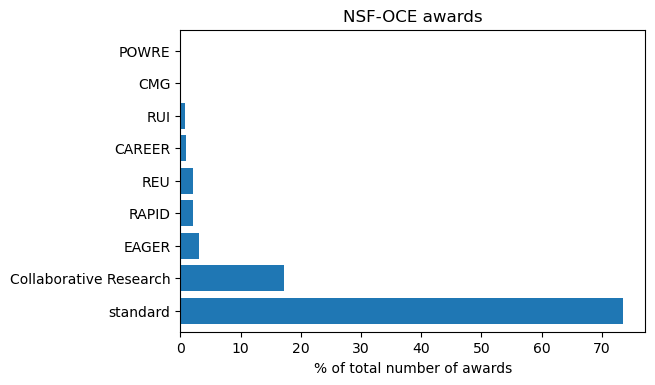

In [58]:
atypes = pd.DataFrame({'number of awards': awards.award_type.value_counts()})
atypes['percentage of total'] =  atypes['number of awards'] / len(awards) * 100
atypes['cum percentage of total'] = atypes['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = atypes['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total number of awards')

atypes

The number and percentage of each award type in each year between 1987 2019.

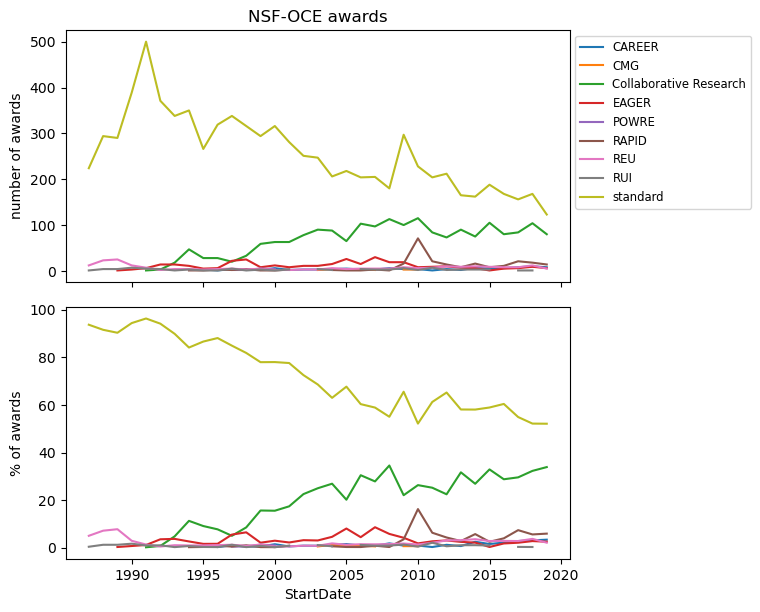

In [59]:
atype_year = awards.groupby([awards.StartDate.dt.year,'award_type'])['Abstract'].count().unstack()
atype_year_pct = atype_year.divide(num_awards_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.5,7))
fig.subplots_adjust(hspace=0.1)
_ = atype_year.plot(ax=axs[0]).legend(bbox_to_anchor=(1, 1))
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards')
_ = atype_year_pct.plot(ax=axs[1], legend=False)
_ = axs[1].set_ylabel('% of awards')

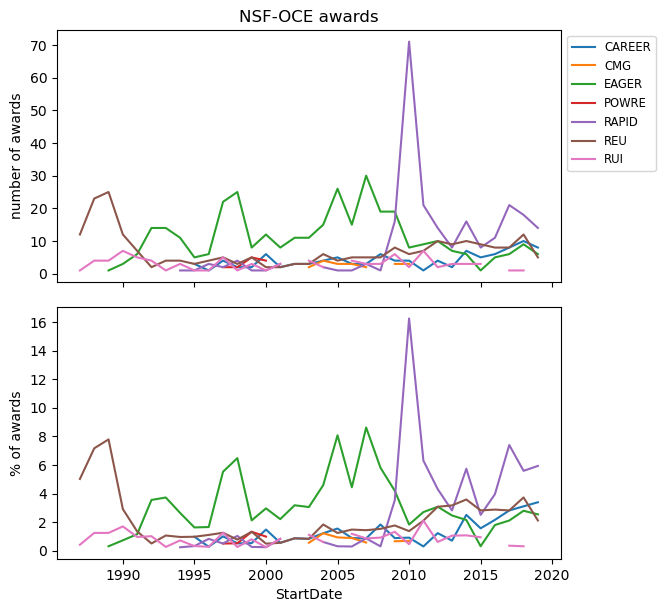

In [60]:
types = ['CAREER','CMG','EAGER','POWRE','RAPID','REU','RUI']
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.5,7))
fig.subplots_adjust(hspace=0.1)
_ = atype_year[types].plot(ax=axs[0]).legend(bbox_to_anchor=(1.2, 1))
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards')
_ = atype_year_pct[types].plot(ax=axs[1], legend=False)
_ = axs[1].set_ylabel('% of awards')

### Amount awarded

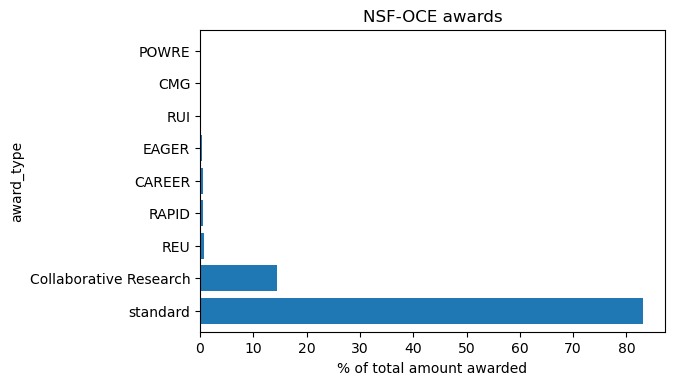

In [61]:
atype_amount = pd.DataFrame(
    {'amount awarded':
     awards.groupby('award_type')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
atype_amount['percentage of total'] = (atype_amount['amount awarded'] / atype_amount['amount awarded'].sum()
                                       * 100)
atype_amount['cum percentage of total'] = atype_amount['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = atype_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total amount awarded')

atype_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by award type.

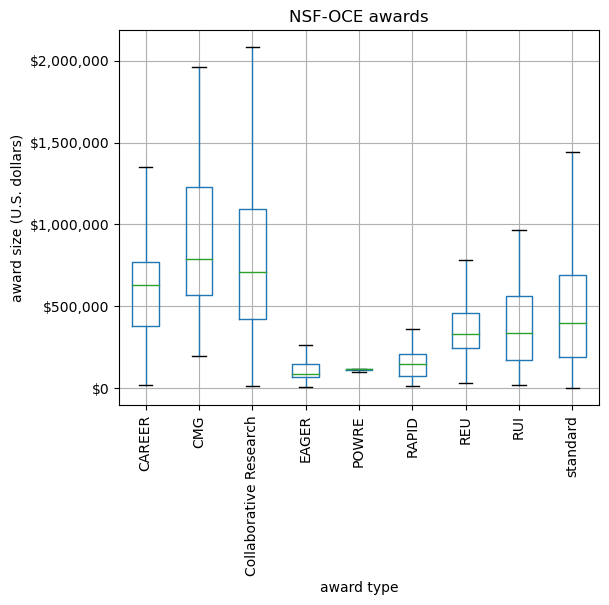

In [62]:
fig, ax = plt.subplots(figsize=(6, 5))
_ = awards.boxplot('tot_amount_adjusted', by='award_type', showfliers=False, rot=90, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards', ylabel='award size (U.S. dollars)', xlabel='award type')
_ = fig.suptitle('')

Boxplot of award interdisciplinarity by award type.

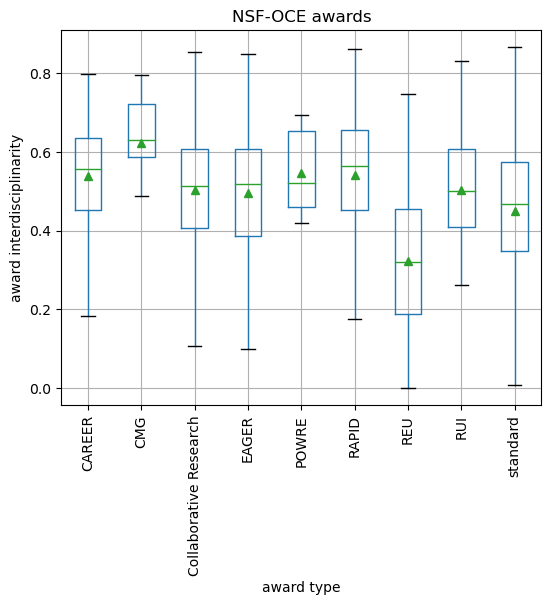

In [63]:
fig, ax = plt.subplots(figsize=(6, 5))
_ = awards.boxplot('evenness', by='award_type', showfliers=False, showmeans=True, rot=90, ax=ax)
_ = ax.set(title='NSF-OCE awards', ylabel='award interdisciplinarity', xlabel='award type')
_ = fig.suptitle('')

The annual amount awarded and percentage of annual amount awarded for each award type between 1987 2019.

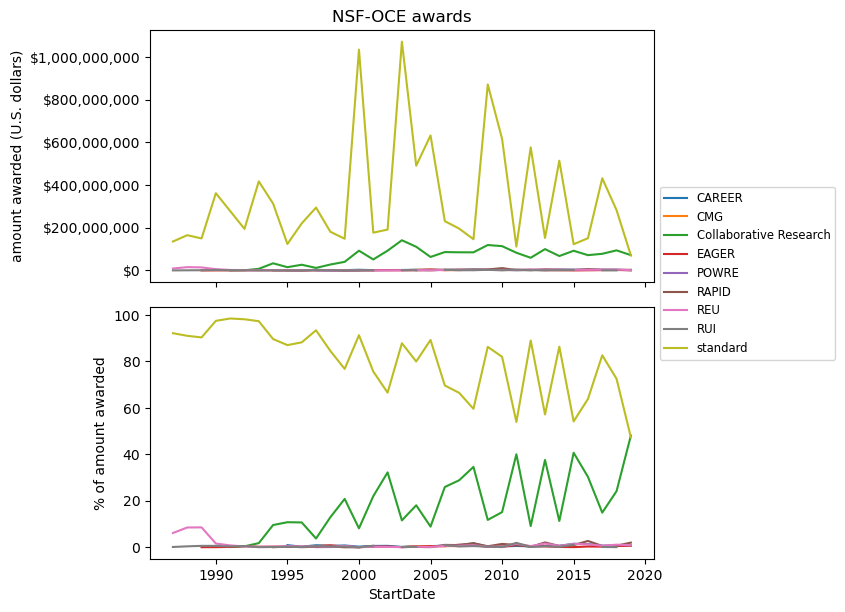

In [64]:
atype_year_amount = awards.groupby(
    [awards.StartDate.dt.year,'award_type'])['tot_amount_adjusted'].sum().unstack()
atype_year_amount_pct = atype_year_amount.divide(amount_per_year, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.5,7))
fig.subplots_adjust(hspace=0.1)
_ = atype_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = atype_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

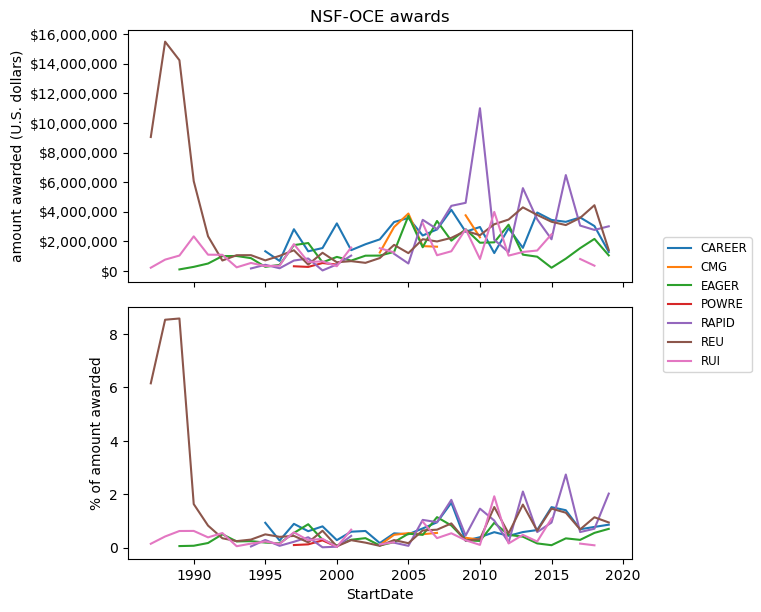

In [65]:
types = ['CAREER','CMG','EAGER','POWRE','RAPID','REU','RUI']
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.5,7))
fig.subplots_adjust(hspace=0.1)
_ = atype_year_amount[types].plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = atype_year_amount_pct[types].plot(ax=axs[1]).legend(bbox_to_anchor=(1.25, 1.3))
_ = axs[1].set_ylabel('% of amount awarded')

### Frequency distribution of award types by PI gender

The table and figure below show the relative frequency of different award types by PI gender. The table and figure show how the awards from each gender (PI) are distributed across the different award types. The differences are small but *standard* awards make up a lower proportion of the awards to female PIs and *Collaborative Research* and other types of awards take up a higher percentage of those awards. *Collaborative Research* awards comprise about 21% of awards to female PIs, compared to 16% for male PIs, while *standard* awards cromprise about 66% of awards to female PIs, compared to 75% for male PIs.

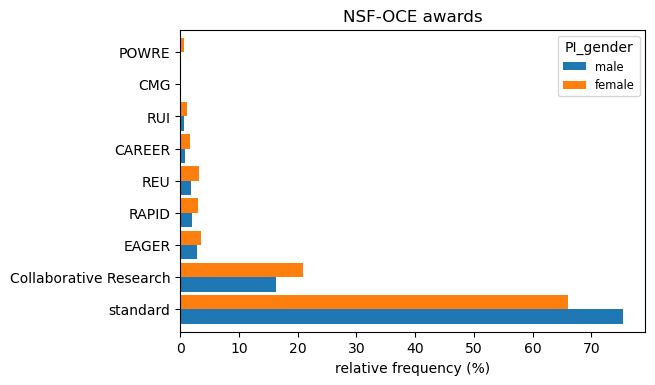

In [66]:
df_atype = awards.groupby(['award_type','PI_gender'])['Abstract'].count().unstack().fillna(0)
df_atype = df_atype/df_atype.sum() * 100
# df_atype = df_atype.sort_values('female', ascending=False)
df_atype = df_atype.reindex(atypes.index)

fig, ax = plt.subplots()
_ = df_atype[['male','female']].dropna().plot(kind='barh', width=0.9, ax=ax)
_ = ax.set(title='NSF-OCE awards', xlabel='relative frequency (%)')

df_atype.style.format('{:.2f}')

The cummulative relative frequency of different award types (table below) shows that "non-standard" awards comprise about 34% of awards to female PIs, compared to 25% for male Pis.

In [67]:
df_atype.sort_values('female').cumsum().style.format('{:.2f}')

### Gender composition across award types

PI gender percentage across award types.

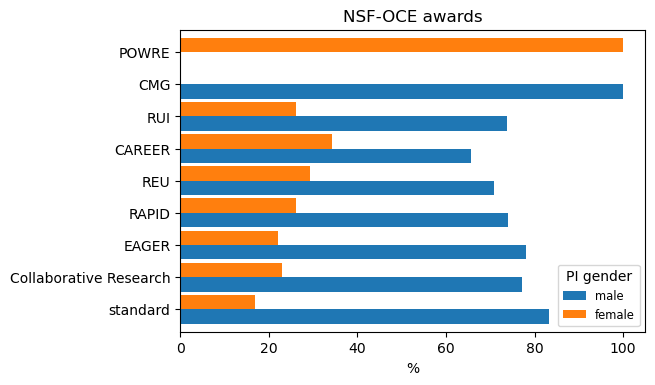

In [68]:
df = awards.groupby(['award_type','PI_gender'])['Abstract'].count().unstack()
by_atype_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
# by_atype_pi = by_atype_pi.sort_values('male') * 100 # fraction -> percentage
by_atype_pi = by_atype_pi.reindex(atypes.index) * 100 # fraction -> percentage

fig, ax = plt.subplots()
_ = by_atype_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(title='PI gender',loc='lower right')
_ = ax.set(title='NSF-OCE awards', xlabel='%')

by_atype_pi.style.format('{:.2f}')

co-PI gender percentage across award types.

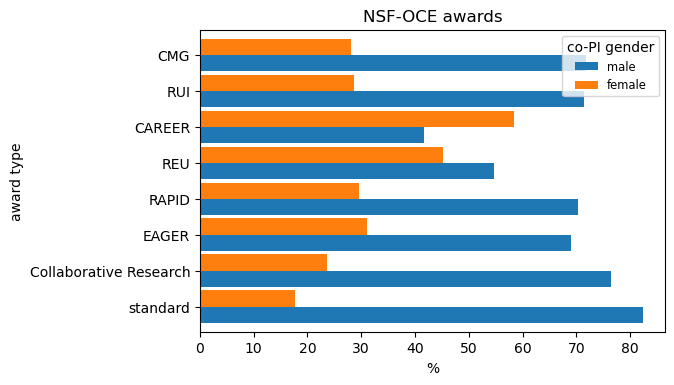

In [69]:
by_atype_copi = pd.DataFrame({'female': awards.groupby(['award_type'])['co-PI_female_frac'].mean()})
by_atype_copi['male'] = 1 - by_atype_copi.female
by_atype_copi.columns.name = 'co-PI gender'
# by_atype_copi = by_atype_copi.sort_values('male') * 100 # fraction -> percentage
by_atype_copi = by_atype_copi.reindex(atypes.index) * 100 # fraction -> percentage

fig, ax = plt.subplots()
_ = by_atype_copi[['male','female']].dropna().plot(kind='barh', ax=ax, width=0.9).legend(title='co-PI gender',loc='upper right')
_ = ax.set(title='NSF-OCE awards', xlabel='%', ylabel='award type')

by_atype_copi.style.format('{:.2f}')

Combining the 3 bar plots above into one bubble plot. The size of the bubble corresponds to the ratio between the percentage of awards from female and male PIs in each award type. A ratio greater than one means female PIs have a larger percentage of awards in that award type than male PIs, and vice-versa.

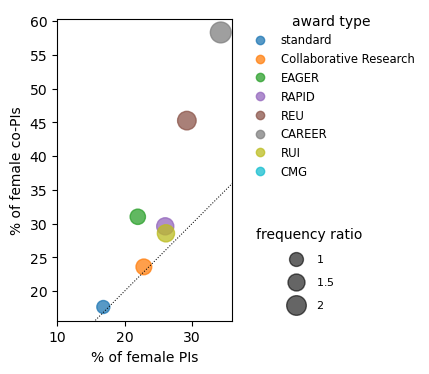

In [70]:
by_atype = pd.DataFrame({'PI': by_atype_pi.female,'co-PI':by_atype_copi.female,
                         'frequency': df_atype.female/df_atype.male * 100})
by_atype = by_atype.loc[df_atype.index,:]
by_atype['color'] = np.arange(len(by_atype_pi))
by_atype = by_atype.drop('POWRE')

n_types = len(by_atype)
fig, ax = plt.subplots()
sp = ax.scatter(by_atype['PI'], by_atype['co-PI'], c=by_atype['color'], s=by_atype.frequency, cmap=plt.cm.tab10, alpha=0.75)
_ = ax.axis('scaled')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
_ = ax.set(xlim=(10,xmax), xlabel='% of female PIs', ylabel='% of female co-PIs')
_ = ax.plot([0,ymax],[0,ymax],':',color='k',linewidth=0.75)

labels = [p for p in by_atype.index]
handles, foo = sp.legend_elements()
l1 = ax.legend(handles, labels ,loc="upper right", bbox_to_anchor=(2.1, 1.05), title='award type', frameon=False)
_ = ax.add_artist(l1)

# handles2, labels2 = sp.legend_elements(prop='sizes', num=[200,600,1200], alpha=0.6)
# labels2 = ['$\\mathdefault{10}$','$\\mathdefault{30}$','$\\mathdefault{60}$']
handles2, labels2 = sp.legend_elements(prop='sizes', num=[100, 150, 200], alpha=0.6)
labels2 = ['$\\mathdefault{1}$','$\\mathdefault{1.5}$','$\\mathdefault{2}$']
l2 = ax.legend(handles2, labels2, loc='lower right', bbox_to_anchor=(1.8, 0), title='frequency ratio',
               fontsize=8, frameon=False, labelspacing=1)

### Changes in gender composition across award types

The figure below shows time series of the annual percentage of female PIs and co-PIs for each NSF-OCE award types. Solid lines represent the linear regression fit and points represent the individual years. If the p-value for the regression slope is not significant ($p<0.05$) the regression line is not plotted. The table shows the linear regressions results.

Except for *Collaborative Research* and *standard* awards, the number of awards per year in each award type is small, therefore the variability is high. Many award types don't have enough points to fit a linear regression.

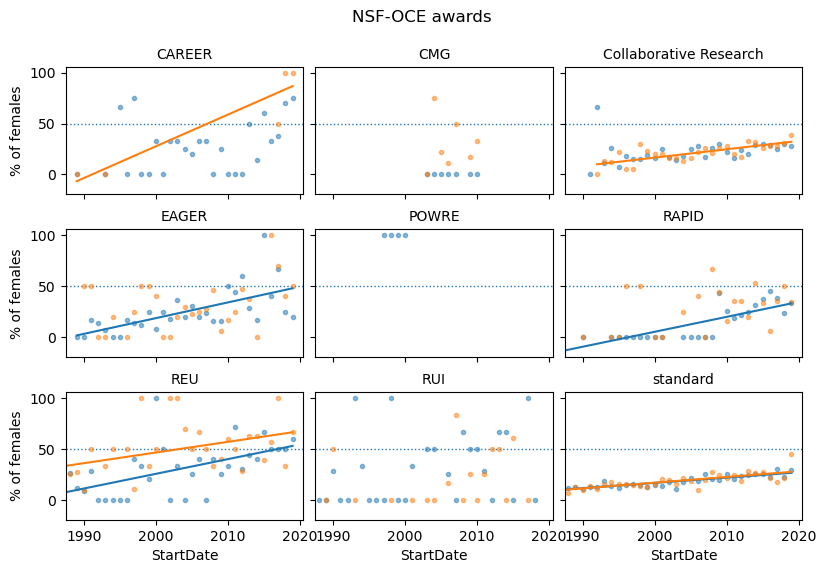

In [71]:
# female & male fraction of PIs
df = awards.groupby(['award_type',awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_atype = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_by_atype = pd.DataFrame({'female': 
                   awards.groupby(['award_type',awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_atype['male'] = 1 - copi_gender_by_atype.female

female_pct_by_atype = pd.DataFrame({'PI':pi_gender_by_atype['female'] * 100,
                                    'co-PI': copi_gender_by_atype['female'] * 100})

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9.5, 6))
fig.subplots_adjust(hspace=0.275, wspace=0.05)
params = []
for ax, atype in zip(axs.ravel(), female_pct_by_atype.index.levels[0]):
    if atype == 'CMG':
        legend = True
    else:
        legend=False
    _ = female_pct_by_atype.loc[atype].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=alpha)

    reg1, X = linreg(female_pct_by_atype.loc[atype].index, female_pct_by_atype.loc[atype].PI)
    if reg1.pvalues[1]<0.05:
        _ = ax.plot(female_pct_by_atype.loc[atype].index, reg1.predict(X), 'C0')
    y = female_pct_by_atype.loc[atype,'co-PI'].dropna()
    if y.size > 1:
        reg2, X = linreg(female_pct_by_atype.loc[atype].dropna().index, y)
        rs, sl, pv = reg2.rsquared,reg2.params[1],reg2.pvalues[1]
        if reg2.pvalues[1]<0.05:
            _ = ax.plot(female_pct_by_atype.loc[atype].dropna().index, reg2.predict(X), 'C1')
    else:
        rs, sl, pv = np.nan, np.nan, np.nan

    params.append([reg1.rsquared,reg1.params[1],reg1.pvalues[1],rs, sl, pv])

    _ = ax.set_title(atype, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(50, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)

for i in range(3):
    _ = axs[i,0].set_ylabel('% of females')

_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=female_pct_by_atype.index.levels[0],
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female percentage/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the different award type. The table shows the sum of the anomalies for each award type which is a metric of how each award type is performing relative to the academic workforce. Positive and negative values indicate that the award type is overperforming and underperforming female representation in the academic workforce, respectively.

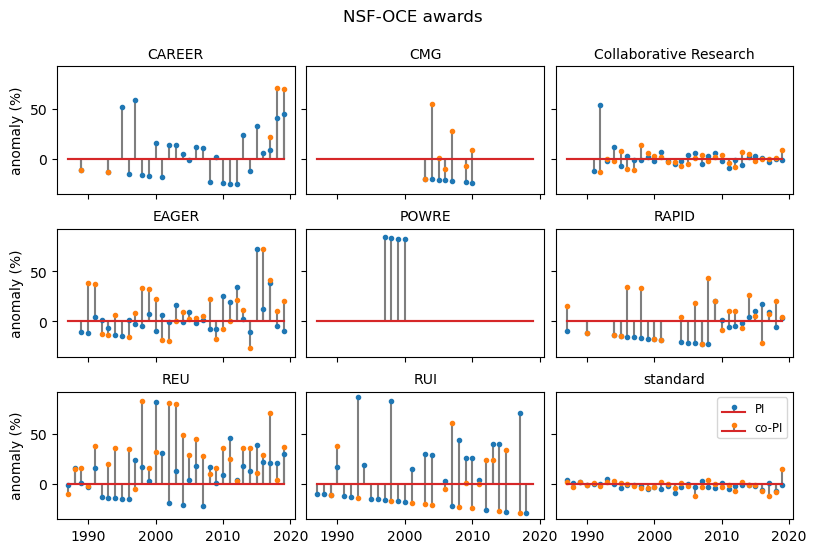

In [72]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9.5, 6))
fig.subplots_adjust(hspace=0.275, wspace=0.05)
params = []
for ax, atype in zip(axs.ravel(), female_pct_by_atype.index.levels[0]):
    if atype == 'CMG':
        legend = True
    else:
        legend=False

    anom = female_pct_by_atype.loc[atype] - df_ref
    _ = ax.stem(anom.index.values, anom.PI, markerfmt='C0.', linefmt='C7', label='PI')
    _ = ax.stem(anom.index.values, anom['co-PI'], markerfmt='C1.', linefmt='C7', label='co-PI')
#     _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
#     _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
#     _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
#     _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)           
    _ = ax.set_title(atype, fontsize=10)
#     x0, x1 = ax.get_xlim()
#     _ = ax.hlines(0, x0, x1, linestyles='dotted', linewidth=1, colors='k', alpha=0.5)
#     _ = ax.set_xlim(x0,x1)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(3):
    _ = axs[i,0].set_ylabel('anomaly (%)')

_ = ax.legend(loc='best')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

df_anom = pd.DataFrame(data=params, index=female_pct_by_atype.index.levels[0], columns=['PI', 'co-PI'])
df_anom.columns.name = 'total sum'
df_anom.style.format('{:.2f}')